# Курсовой проект к дисциплине Библиотеки Python

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
TRAIN_DATASET_PATH = 'C:/Ангелина/Data Sience/1 четверть/Библиотеки Python/Проект/train.csv'
TEST_DATASET_PATH = 'C:/Ангелина/Data Sience/1 четверть/Библиотеки Python/Проект/test.csv'

## 1. Постановка задачи

Цель - оценивать стоимость квартиры

## 2. Получение данных

Статистические данные о ряде квартир в России.
**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

## 3. Анализ данных

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')

In [7]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [8]:
df.shape

(10000, 20)

In [9]:
df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

## 4. Визуализация данных

In [10]:
df.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630


In [11]:
df.tail(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [12]:
df.sample(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
104,4496,7,3.0,73.441848,46.421889,9.0,8,16.0,2012,0.130618,B,B,39,10418,9,900.0,1,9,B,199179.725895
1621,7586,0,2.0,45.662268,30.086910,6.0,4,5.0,1959,0.319809,B,B,25,4756,16,2857.0,5,8,B,221660.251771
4044,9726,12,3.0,76.251158,49.134125,10.0,9,17.0,1992,0.090799,B,B,74,19083,2,NaN,5,15,B,89986.645751
8832,3840,27,1.0,40.164392,39.777293,10.0,16,17.0,2018,0.011654,B,B,4,915,0,NaN,0,0,B,121544.405184
7898,5189,47,1.0,42.221889,19.839307,8.0,8,19.0,2009,0.101872,B,B,23,4583,3,NaN,3,3,B,176570.405274
5021,11127,27,1.0,45.769593,19.110043,1.0,7,9.0,2017,0.017647,B,B,2,469,0,NaN,0,0,B,137970.693985
8983,15192,26,3.0,117.714551,57.440648,15.0,17,30.0,2012,0.000000,B,B,36,6714,2,2672.0,0,2,B,624680.099059
1952,4043,46,1.0,39.418419,40.090964,1.0,15,1.0,2014,0.000000,B,B,47,11319,0,1145.0,3,5,B,229770.376527
2336,12614,4,4.0,133.972934,81.583849,14.0,7,18.0,2014,0.327018,B,B,12,2270,23,2500.0,1,0,B,197302.241882
7253,958,1,2.0,65.388796,NaN,1.0,11,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,212185.906984


In [13]:
df[df['Rooms'] == 0].sample(8) # 0 комнат у 8-ми квартир

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9767,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
9869,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788


In [14]:
df[df['Price'] > 0].agg([np.min, np.mean, np.max])

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
amin,0.0000,0.0000,0.0000,1.136859,0.370619,0.0000,1.0000,0.0000,1.910000e+03,0.000000,A,A,0.000,168.0000,0.0000,0.00000,0.0000,0.0000,A,59174.778028
mean,8383.4077,50.4008,1.8905,56.315775,37.199645,6.2733,8.5267,12.6094,3.990166e+03,0.118858,NaN,NaN,24.687,5352.1574,8.0392,1142.90446,1.3195,4.2313,NaN,214138.857399
amax,16798.0000,209.0000,19.0000,641.065193,7480.592129,2014.0000,42.0000,117.0000,2.005201e+07,0.521867,B,B,74.000,19083.0000,141.0000,4849.00000,6.0000,23.0000,B,633233.466570


In [15]:
df[(df['HouseFloor'] < 5) & (df['Floor'] > 5)].head() # этажность дома меньше, чем этаж квартиры

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
25,4521,6,2.0,65.409965,NaN,1.0,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608
26,8553,88,3.0,83.262530,4.769174,1.0,13,1.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,410883.892020
44,9024,6,3.0,79.790762,NaN,1.0,16,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,193595.800511
47,6186,1,1.0,62.006079,NaN,1.0,7,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,197006.124188
71,13726,27,1.0,47.557691,22.682321,1.0,16,1.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,130190.643579


In [16]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [17]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [18]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


## 5. Разбиение данных на train и valid

## 5.1 Разделение на target и feature датасеты

In [19]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [20]:
target = 'Price'

In [21]:
feature_names = ['Id','DistrictId','Rooms','Square','LifeSquare','KitchenSquare','Floor','HouseFloor','HouseYear','Ecology_1',
                 'Ecology_2','Ecology_3','Social_1','Social_2','Social_3','Healthcare_1','Helthcare_2','Shops_1','Shops_2']

Создадим два датафрейма

In [22]:
X = pd.DataFrame(df, columns=feature_names)
X.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B


In [23]:
y = pd.DataFrame(df, columns=['Price'])
y.head()

,Price
0,305018.871089
1,177734.553407
2,282078.720850
3,168106.007630
4,343995.102962


## 5.2 Разделение на тренировочный и тестовый датасеты

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

## 5.3 Тестовый датасет

In [26]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')

In [27]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


## 6. Переработка данных

## 6.1 Обработка нулевых значений и NaN. 

## 6.1.1 Пропуски

In [28]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

## 6.1.1.1 LifeSquare_nan

Обработка 2-х столбцов: LifeSquare и Healtcare_1. Создадим вспомогательный признак и заполним его 0, если пропуска в LifeSquare нет и 1, когда пропуски есть.

In [29]:
X_train['LifeSquare_nan'] = 0
X_valid['LifeSquare_nan'] = 0
test_df['LifeSquare_nan'] = 0
X_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan
4901,14277,99,2.0,57.352825,36.375196,9.0,8,14.0,1998,0.033494,B,B,66,10573,1,1322.0,3,8,B,0
4375,10094,48,3.0,79.705401,47.831885,10.0,15,17.0,1984,0.041125,B,B,46,9515,5,NaN,1,10,B,0
6698,7580,150,2.0,47.230717,30.442536,6.0,10,12.0,1971,0.020741,B,B,24,5613,5,1340.0,2,5,B,0
9805,1644,6,1.0,39.147138,38.473125,1.0,17,17.0,2017,0.243205,B,B,5,1564,0,540.0,0,0,B,0
1101,3606,4,2.0,45.595236,29.986188,5.0,5,5.0,1961,0.042032,B,B,37,6856,84,1940.0,2,5,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,6137,22,3.0,79.650439,NaN,1.0,19,20.0,1977,0.118537,B,B,30,6207,1,1183.0,1,0,B,0
5191,4451,1,3.0,79.953687,NaN,1.0,12,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,0
5390,13236,11,1.0,39.698660,25.570715,7.0,5,9.0,1982,0.038693,B,B,28,6533,1,1015.0,2,5,B,0
860,10404,6,1.0,43.613432,3.668460,1.0,3,17.0,2016,0.243205,B,B,5,1564,0,540.0,0,0,B,0


In [30]:
X_train.loc[X_train['LifeSquare'].isna(), 'LifeSquare_nan']
X_valid.loc[X_valid['LifeSquare'].isna(), 'LifeSquare_nan']
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare_nan']

2       0
4       0
11      0
13      0
14      0
       ..
4985    0
4986    0
4988    0
4989    0
4993    0
Name: LifeSquare_nan, Length: 1041, dtype: int64

In [31]:
X_train.loc[X_train['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
X_valid.loc[X_valid['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1

In [32]:
X_valid[X_valid['LifeSquare_nan'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan
4684,13670,22,1.0,87.485627,NaN,0.0,16,0.0,1977,0.118537,B,B,30,6207,1,1183.0,1,0,B,1
7487,14720,27,3.0,75.197788,NaN,0.0,16,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,1
9930,3659,27,2.0,56.812696,NaN,1.0,11,9.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,1
4947,14344,30,2.0,63.816844,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,1
6590,122,23,1.0,43.986984,NaN,1.0,3,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3651,3215,6,2.0,61.521269,NaN,0.0,10,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,1
3297,4969,23,2.0,48.377308,NaN,1.0,2,3.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,1
8043,8308,27,1.0,42.475577,NaN,10.0,12,20.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,1
2760,2091,62,3.0,88.819770,NaN,1.0,6,17.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,1


In [33]:
# проверка метода fillna (заполнить пропуски)
median = X_train['LifeSquare'].median()
X_train['LifeSquare'].fillna(median).isna().sum()
X_valid['LifeSquare'].fillna(median).isna().sum()
test_df['LifeSquare'].fillna(median).isna().sum()

0

In [34]:
X_train['LifeSquare'].isna().sum()

1601

In [35]:
# заполняем медианой
X_train['LifeSquare'] = X_train['LifeSquare'].fillna(median)
X_valid['LifeSquare'] = X_valid['LifeSquare'].fillna(median)
test_df['LifeSquare'] = test_df['LifeSquare'].fillna(median)

In [36]:
X_train.isna().sum()

Id                   0
DistrictId           0
Rooms                0
Square               0
LifeSquare           0
KitchenSquare        0
Floor                0
HouseFloor           0
HouseYear            0
Ecology_1            0
Ecology_2            0
Ecology_3            0
Social_1             0
Social_2             0
Social_3             0
Healthcare_1      3633
Helthcare_2          0
Shops_1              0
Shops_2              0
LifeSquare_nan       0
dtype: int64

## 6.1.1.2 Healthcare_1_nan

Создадим вспомогательный признак и заполним его 0, если пропуска в Healthcare_1 нет и 1, когда пропуски есть.

In [37]:
X_train['Healthcare_1_nan'] = 0
X_valid['Healthcare_1_nan'] = 0
test_df['Healthcare_1_nan'] = 0
X_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
4901,14277,99,2.0,57.352825,36.375196,9.0,8,14.0,1998,0.033494,...,B,66,10573,1,1322.0,3,8,B,0,0
4375,10094,48,3.0,79.705401,47.831885,10.0,15,17.0,1984,0.041125,...,B,46,9515,5,NaN,1,10,B,0,0
6698,7580,150,2.0,47.230717,30.442536,6.0,10,12.0,1971,0.020741,...,B,24,5613,5,1340.0,2,5,B,0,0
9805,1644,6,1.0,39.147138,38.473125,1.0,17,17.0,2017,0.243205,...,B,5,1564,0,540.0,0,0,B,0,0
1101,3606,4,2.0,45.595236,29.986188,5.0,5,5.0,1961,0.042032,...,B,37,6856,84,1940.0,2,5,B,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,6137,22,3.0,79.650439,32.641537,1.0,19,20.0,1977,0.118537,...,B,30,6207,1,1183.0,1,0,B,1,0
5191,4451,1,3.0,79.953687,32.641537,1.0,12,17.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,1,0
5390,13236,11,1.0,39.698660,25.570715,7.0,5,9.0,1982,0.038693,...,B,28,6533,1,1015.0,2,5,B,0,0
860,10404,6,1.0,43.613432,3.668460,1.0,3,17.0,2016,0.243205,...,B,5,1564,0,540.0,0,0,B,0,0


In [38]:
X_train.loc[X_train['Healthcare_1'].isna(), 'Healthcare_1_nan']
X_valid.loc[X_valid['Healthcare_1'].isna(), 'Healthcare_1_nan']
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1_nan']

1       0
2       0
3       0
6       0
7       0
       ..
4988    0
4989    0
4994    0
4995    0
4998    0
Name: Healthcare_1_nan, Length: 2377, dtype: int64

In [39]:
X_train.loc[X_train['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
X_valid.loc[X_valid['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1

In [40]:
X_valid[X_valid['Healthcare_1_nan'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
4742,11707,41,1.0,42.909800,20.923332,9.0,14,16.0,1980,0.175055,...,B,36,10055,3,NaN,1,0,B,0,1
2750,2582,47,3.0,79.148545,49.527374,10.0,5,16.0,1983,0.101872,...,B,23,4583,3,NaN,3,3,B,0,1
7487,14720,27,3.0,75.197788,32.641537,0.0,16,19.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,1,1
9930,3659,27,2.0,56.812696,32.641537,1.0,11,9.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,1,1
8158,15467,27,1.0,48.406065,18.154850,1.0,16,16.0,2014,0.017647,...,B,2,469,0,NaN,0,0,B,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4759,9081,27,1.0,34.396472,35.005440,1.0,14,17.0,2016,0.011654,...,B,4,915,0,NaN,0,0,B,0,1
4862,10130,56,4.0,103.320696,67.811931,10.0,10,22.0,1999,0.000000,...,B,23,5067,4,NaN,2,6,B,0,1
7647,13531,124,2.0,38.385068,23.058818,6.0,7,14.0,1975,0.169091,...,B,19,3856,10,NaN,2,5,B,0,1
7161,12550,98,2.0,49.891352,30.158352,5.0,4,5.0,1962,0.195781,...,B,23,5212,6,NaN,3,2,B,0,1


In [41]:
# проверка метода fillna (заполнить пропуски)
median = X_train['Healthcare_1'].median()
X_train['Healthcare_1'].fillna(median).isna().sum()
X_valid['Healthcare_1'].fillna(median).isna().sum()
test_df['Healthcare_1'].fillna(median).isna().sum()

0

In [42]:
X_train['Healthcare_1'].isna().sum()

3633

In [43]:
# заполняем медианой
X_train['Healthcare_1'] = X_train['Healthcare_1'].fillna(median)
X_valid['Healthcare_1'] = X_valid['Healthcare_1'].fillna(median)
test_df['Healthcare_1'] = test_df['Healthcare_1'].fillna(median)

In [44]:
X_valid.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Shops_2             0
LifeSquare_nan      0
Healthcare_1_nan    0
dtype: int64

In [45]:
X_train = X_train.drop('LifeSquare_nan', axis=1)
X_valid = X_valid.drop('LifeSquare_nan', axis=1)
test_df = test_df.drop('LifeSquare_nan', axis=1)

X_train = X_train.drop('Healthcare_1_nan', axis=1)
X_valid = X_valid.drop('Healthcare_1_nan', axis=1)
test_df = test_df.drop('Healthcare_1_nan', axis=1)

## 6.1.2 Обработка нулевых значений

## 6.1.2.1 Rooms

In [46]:
X_train.loc[X_train['Rooms'] == 0, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
5894,770,28,0.0,49.483501,32.641537,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B
7929,456,6,0.0,81.491446,32.641537,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
9869,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,900.0,3,9,B
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B


In [47]:
X_valid.loc[X_valid['Rooms'] == 0, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,900.0,0,1,B
3780,7317,27,0.0,41.790881,32.641537,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B
9767,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,900.0,0,0,B


In [48]:
test_df.loc[test_df['Rooms'] == 0, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
961,3343,58,0.0,116.824201,113.692424,0.0,3,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
4179,10729,27,0.0,76.345154,42.820796,12.0,14,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B


In [49]:
X_train['Rooms'] = X_train['Rooms'].replace(0, X_train['Rooms'].median())
X_valid['Rooms'] = X_valid['Rooms'].replace(0, X_train['Rooms'].median())
test_df['Rooms'] = test_df['Rooms'].replace(0, X_train['Rooms'].median())

In [50]:
X_train.loc[X_train['Rooms'] == 0, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


## 6.1.2.2 KitchenSquare

In [51]:
X_train.loc[X_train['KitchenSquare'] == 0, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
6835,6749,23,2.0,65.204976,2.467002,0.0,9,17.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B
9703,5228,6,2.0,67.610000,32.641537,0.0,8,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
1421,9231,1,3.0,88.217099,32.641537,0.0,16,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B
6993,790,23,1.0,41.074417,32.641537,0.0,9,17.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B
9253,6056,6,1.0,52.231568,32.641537,0.0,12,25.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8226,4376,23,1.0,32.010776,30.477298,0.0,14,17.0,2016,0.034656,B,B,0,168,0,900.0,0,0,B
5393,3560,1,3.0,80.442668,78.437146,0.0,5,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B
7734,10947,6,1.0,43.085940,32.641537,0.0,10,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
5051,1737,23,1.0,59.963701,32.641537,0.0,9,0.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B


In [52]:
X_valid.loc[X_valid['KitchenSquare'] == 0, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4684,13670,22,1.0,87.485627,32.641537,0.0,16,0.0,1977,0.118537,B,B,30,6207,1,1183.0,1,0,B
7487,14720,27,3.0,75.197788,32.641537,0.0,16,19.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B
9485,7198,48,2.0,80.294115,81.452946,0.0,21,0.0,1977,0.041125,B,B,46,9515,5,900.0,1,10,B
2678,7882,62,1.0,45.573548,44.462279,0.0,4,17.0,2015,0.072158,B,B,2,629,1,900.0,0,0,A
8284,16066,27,2.0,66.617933,31.546184,0.0,4,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,7388,34,4.0,95.988520,32.641537,0.0,4,0.0,1977,0.069753,B,B,53,13670,4,900.0,1,11,B
9444,11944,53,3.0,80.488807,77.987733,0.0,5,19.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
7163,4083,58,2.0,66.357288,65.874526,0.0,3,12.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
834,892,74,1.0,48.166394,50.044329,0.0,3,16.0,2018,0.075779,B,B,6,1437,3,900.0,0,2,B


In [53]:
test_df.loc[test_df['KitchenSquare'] == 0, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
30,9245,1,2.0,63.115041,32.641537,0.0,4,24.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B
41,13151,25,1.0,29.249108,32.641537,0.0,22,25.0,2016,0.069753,B,B,53,13670,4,900.0,1,11,B
45,8174,23,1.0,46.886836,32.641537,0.0,3,3.0,2016,0.034656,B,B,0,168,0,900.0,0,0,B
52,15989,62,1.0,47.095406,32.641537,0.0,4,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A
58,1814,1,1.0,41.115609,41.171464,0.0,4,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4960,15412,23,2.0,52.743808,32.641537,0.0,4,3.0,1977,0.005767,B,B,1,388,0,900.0,0,0,B
4972,5873,52,2.0,52.768718,32.641537,0.0,13,17.0,1977,0.371149,B,B,34,7065,1,750.0,2,5,B
4978,15243,53,2.0,56.872925,32.641537,0.0,20,0.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
4979,4821,74,2.0,82.542507,82.585069,0.0,4,17.0,2015,0.309479,B,B,35,7715,4,990.0,0,6,B


In [54]:
X_train['KitchenSquare'] = X_train['KitchenSquare'].replace(0, X_train['KitchenSquare'].median())
X_valid['KitchenSquare'] = X_valid['KitchenSquare'].replace(0, X_train['KitchenSquare'].median())
test_df['KitchenSquare'] = test_df['KitchenSquare'].replace(0, X_train['KitchenSquare'].median())

In [55]:
test_df.loc[test_df['KitchenSquare'] == 0, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


## 6.1.2.3 HouseFloor

In [56]:
X_train.loc[X_train['HouseFloor'] == 0, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
3459,684,27,1.0,39.225233,18.971950,11.0,5,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B
9557,10279,2,2.0,61.718648,61.809928,6.0,9,0.0,1977,0.130618,B,B,39,10418,9,900.0,1,9,B
5395,10199,74,1.0,54.662565,32.641537,6.0,5,0.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B
6618,5225,93,3.0,135.425513,32.641537,6.0,2,0.0,1977,0.004949,B,B,0,186,0,900.0,0,0,B
9175,15099,27,3.0,57.114308,32.641537,6.0,18,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5134,13552,62,2.0,71.567578,32.641537,6.0,7,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A
9762,12793,27,1.0,44.994540,32.641537,6.0,2,0.0,1977,0.011654,B,B,4,915,0,900.0,0,0,B
5258,10678,17,4.0,170.016872,32.641537,6.0,12,0.0,1977,0.093443,B,B,23,4635,5,3300.0,2,4,B
878,16368,58,2.0,70.290947,70.052730,6.0,17,0.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B


In [57]:
X_valid.loc[X_valid['HouseFloor'] == 0, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4684,13670,22,1.0,87.485627,32.641537,6.0,16,0.0,1977,0.118537,B,B,30,6207,1,1183.0,1,0,B
9485,7198,48,2.0,80.294115,81.452946,6.0,21,0.0,1977,0.041125,B,B,46,9515,5,900.0,1,10,B
8284,16066,27,2.0,66.617933,31.546184,6.0,4,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B
5861,12828,27,1.0,40.288833,1.487210,6.0,11,0.0,2016,0.211401,B,B,9,1892,0,900.0,0,1,B
4049,2124,62,1.0,45.592499,32.641537,6.0,12,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6532,9384,59,3.0,98.607328,32.641537,6.0,14,0.0,1977,0.019509,B,B,37,7687,11,176.0,5,5,B
3038,9925,62,1.0,42.805164,32.641537,6.0,14,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A
5092,4005,35,2.0,61.253236,32.641537,6.0,7,0.0,1977,0.089040,B,B,33,7976,5,900.0,0,11,B
2373,12204,58,1.0,56.621217,47.732147,6.0,3,0.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B


In [58]:
test_df.loc[test_df['HouseFloor'] == 0, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
52,15989,62,1.0,47.095406,32.641537,6.0,4,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A
61,12694,27,3.0,83.670032,46.358356,6.0,8,0.0,2015,0.072158,B,B,2,629,1,900.0,0,0,A
93,6257,62,1.0,43.835919,32.641537,6.0,9,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A
95,902,27,3.0,99.293191,32.641537,6.0,2,0.0,1977,0.075424,B,B,11,3097,0,900.0,0,0,B
164,2559,23,2.0,73.868460,32.641537,6.0,9,0.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4816,6187,45,3.0,79.798209,32.641537,6.0,17,0.0,1977,0.195781,B,B,23,5212,6,900.0,3,2,B
4817,11475,27,1.0,53.263561,32.641537,6.0,9,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A
4928,13900,169,1.0,48.530248,32.641537,6.0,8,0.0,1977,0.178917,B,B,18,3594,4,192.0,1,5,B
4951,113,27,2.0,65.548249,35.071278,6.0,17,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B


In [59]:
X_train['HouseFloor'] = X_train['HouseFloor'].replace(0, X_train['HouseFloor'].median())
X_valid['HouseFloor'] = X_valid['HouseFloor'].replace(0, X_train['HouseFloor'].median())
test_df['HouseFloor'] = test_df['HouseFloor'].replace(0, X_train['HouseFloor'].median())

In [60]:
X_valid.loc[X_valid['HouseFloor'] == 0, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


## 6.2. Обработка выбросов

## 6.2.1  Обработка признака Rooms

In [61]:
X_train.sort_values(['Rooms','LifeSquare'], ascending=[False, False])
X_train.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4901,14277,99,2.0,57.352825,36.375196,9.0,8,14.0,1998,3.349371e-02,B,B,66,10573,1,1322.0,3,8,B
4375,10094,48,3.0,79.705401,47.831885,10.0,15,17.0,1984,4.112463e-02,B,B,46,9515,5,900.0,1,10,B
6698,7580,150,2.0,47.230717,30.442536,6.0,10,12.0,1971,2.074133e-02,B,B,24,5613,5,1340.0,2,5,B
9805,1644,6,1.0,39.147138,38.473125,1.0,17,17.0,2017,2.432045e-01,B,B,5,1564,0,540.0,0,0,B
1101,3606,4,2.0,45.595236,29.986188,5.0,5,5.0,1961,4.203159e-02,B,B,37,6856,84,1940.0,2,5,B
9537,3735,23,1.0,39.067843,32.641537,1.0,16,17.0,1977,7.577876e-02,B,B,6,1437,3,900.0,0,2,B
7655,15222,68,2.0,49.932152,30.017542,6.0,11,12.0,1972,0.000000e+00,B,B,33,7425,1,900.0,2,5,B
5235,5930,199,3.0,71.109206,36.527485,13.0,4,11.0,1962,1.800000e-09,B,B,16,3681,73,1815.0,2,5,B
5165,4678,44,1.0,52.422475,52.549463,1.0,12,19.0,2016,3.612229e-02,B,B,24,4378,0,1036.0,1,1,B
118,2881,85,3.0,72.120067,47.896262,10.0,9,16.0,1982,3.717782e-02,B,B,52,11217,1,2300.0,1,7,B


In [62]:
X_valid.sort_values(['Rooms','LifeSquare'], ascending=[False, False])
X_valid.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
6252,3367,3,3.0,101.862701,99.970065,11.0,7,15.0,2013,0.050900,B,B,43,10621,1,30.0,2,3,B
4684,13670,22,1.0,87.485627,32.641537,6.0,16,12.0,1977,0.118537,B,B,30,6207,1,1183.0,1,0,B
1731,14507,152,2.0,40.649901,22.288673,7.0,6,9.0,1964,0.042032,B,B,37,6856,84,1940.0,2,5,B
4742,11707,41,1.0,42.909800,20.923332,9.0,14,16.0,1980,0.175055,B,B,36,10055,3,900.0,1,0,B
4521,12298,53,1.0,35.108196,22.155378,9.0,5,12.0,1967,0.049637,B,B,34,7759,0,229.0,1,3,B
6340,14334,11,2.0,59.634032,33.268792,9.0,7,13.0,2015,0.038693,B,B,28,6533,1,1015.0,2,5,B
576,4903,59,2.0,61.142882,36.913778,10.0,15,17.0,1988,0.019509,B,B,37,7687,11,176.0,5,5,B
5202,4308,52,1.0,42.191653,22.235533,7.0,15,17.0,2007,0.371149,B,B,34,7065,1,750.0,2,5,B
6363,14658,6,2.0,62.000239,3.428437,1.0,12,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B
439,129,60,1.0,34.491039,18.042006,6.0,6,5.0,1964,0.341072,B,B,27,5664,48,2300.0,3,11,B


In [63]:
test_df.sort_values(['Rooms','LifeSquare'], ascending=[False, False])
test_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,900.0,0,0,A
2,960,27,2.0,59.463678,32.641537,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,900.0,0,0,B
4,746,74,1.0,53.837056,32.641537,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
5,868,38,3.0,87.139994,53.180419,10.0,4,23.0,2011,0.060753,B,B,15,2787,2,520.0,0,7,B
6,672,62,1.0,46.269456,22.820239,11.0,8,17.0,2014,0.072158,B,B,2,629,1,900.0,0,0,A
7,2471,2,2.0,48.172969,29.924204,6.0,4,9.0,1974,0.000000,B,B,33,7425,1,900.0,2,5,B
8,4510,1,1.0,43.153761,21.017596,9.0,10,17.0,2014,0.007122,B,B,1,264,0,900.0,0,1,B
9,8354,62,2.0,62.593787,59.786844,10.0,1,16.0,1981,0.002212,B,B,39,7614,3,900.0,1,5,A


In [64]:
X_train.loc[X_train['Rooms'] > 6, 'Rooms'] = X_train['Rooms'].median()

In [65]:
X_valid.loc[X_valid['Rooms'] > 6, 'Rooms'] = X_train['Rooms'].median()

In [66]:
test_df.loc[test_df['Rooms'] > 6, 'Rooms'] = X_train['Rooms'].median()

## 6.2.3  Обработка признаков Square и LifeSquare

In [67]:
X_train.loc[X_train['Square'] < X_train['LifeSquare'], :] # Общая площадь меньше, чем жилая

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
5165,4678,44,1.0,52.422475,52.549463,1.0,12,19.0,2016,0.036122,B,B,24,4378,0,1036.0,1,1,B
2564,6279,27,1.0,40.907292,42.102736,1.0,17,16.0,2017,0.011654,B,B,4,915,0,900.0,0,0,B
8687,6874,53,1.0,38.751591,39.703850,1.0,5,18.0,2017,0.049637,B,B,34,7759,0,229.0,1,3,B
7774,13942,63,1.0,48.104035,48.705442,10.0,13,17.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B
4382,5421,74,2.0,81.046411,83.259988,11.0,16,22.0,2019,0.075779,B,B,6,1437,3,900.0,0,2,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,15523,63,1.0,49.039357,50.957360,10.0,19,25.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B
161,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,900.0,3,2,B
7099,15758,45,3.0,70.409984,72.588205,8.0,8,9.0,1975,0.014423,B,B,19,3806,4,900.0,0,3,B
1528,2137,9,2.0,46.469859,50.703196,9.0,2,12.0,1966,0.310199,B,B,11,2748,1,900.0,0,0,B


In [68]:
X_valid.loc[X_valid['Square'] < X_valid['LifeSquare'], :] # Общая площадь меньше, чем жилая

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
9485,7198,48,2.0,80.294115,81.452946,6.0,21,12.0,1977,0.041125,B,B,46,9515,5,900.0,1,10,B
4949,12330,74,2.0,78.922350,79.811358,1.0,9,1.0,2016,0.075779,B,B,6,1437,3,900.0,0,2,B
8328,4127,27,1.0,44.383976,46.958655,1.0,4,22.0,2017,0.211401,B,B,9,1892,0,900.0,0,1,B
5547,16209,6,3.0,77.341477,80.610702,1.0,7,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
9655,12692,27,2.0,86.036862,88.541965,1.0,3,22.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7319,5616,85,3.0,105.443592,107.927859,15.0,11,12.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A
9130,1915,30,2.0,68.752862,69.521068,1.0,2,1.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
834,892,74,1.0,48.166394,50.044329,6.0,3,16.0,2018,0.075779,B,B,6,1437,3,900.0,0,2,B
8171,3470,134,1.0,40.045620,41.798216,1.0,8,17.0,1977,0.212515,B,B,19,3293,16,628.0,3,7,B


In [69]:
test_df.loc[test_df['Square'] < test_df['LifeSquare'], :] # Общая площадь меньше, чем жилая

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,900.0,0,0,A
25,14686,1,3.0,77.229885,79.958685,1.0,18,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B
28,10869,23,3.0,78.001888,82.566322,1.0,21,25.0,2015,0.075779,B,B,6,1437,3,900.0,0,2,B
39,16384,1,2.0,52.773671,52.910722,10.0,6,17.0,2017,0.007122,B,B,1,264,0,900.0,0,1,B
41,13151,25,1.0,29.249108,32.641537,6.0,22,25.0,2016,0.069753,B,B,53,13670,4,900.0,1,11,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898,15984,23,3.0,104.786355,106.730272,1.0,14,25.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B
4945,9888,45,2.0,60.501260,60.881119,10.0,24,24.0,2016,0.195781,B,B,23,5212,6,900.0,3,2,B
4970,13494,169,1.0,47.012027,47.372332,8.0,4,17.0,2019,0.178917,B,B,18,3594,4,192.0,1,5,B
4979,4821,74,2.0,82.542507,82.585069,6.0,4,17.0,2015,0.309479,B,B,35,7715,4,990.0,0,6,B


In [70]:
# обработка в пункте 7.2.1.6

In [71]:
X_train.loc[X_train['Square'] < X_train['LifeSquare'] + X_train['KitchenSquare'], :] # Сумма жилой площади и кухни больше, чем общая площадь

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
9805,1644,6,1.0,39.147138,38.473125,1.0,17,17.0,2017,0.243205,B,B,5,1564,0,540.0,0,0,B
5165,4678,44,1.0,52.422475,52.549463,1.0,12,19.0,2016,0.036122,B,B,24,4378,0,1036.0,1,1,B
2564,6279,27,1.0,40.907292,42.102736,1.0,17,16.0,2017,0.011654,B,B,4,915,0,900.0,0,0,B
9714,14021,1,2.0,65.005981,64.549392,1.0,16,20.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B
8687,6874,53,1.0,38.751591,39.703850,1.0,5,18.0,2017,0.049637,B,B,34,7759,0,229.0,1,3,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5393,3560,1,3.0,80.442668,78.437146,6.0,5,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B
3556,387,27,3.0,85.968454,85.038779,9.0,14,17.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A
1528,2137,9,2.0,46.469859,50.703196,9.0,2,12.0,1966,0.310199,B,B,11,2748,1,900.0,0,0,B
1267,1744,27,1.0,39.164012,32.641537,12.0,11,19.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B


In [72]:
X_valid.loc[X_valid['Square'] < X_valid['LifeSquare'] + X_valid['KitchenSquare'], :] # Сумма жилой площади и кухни больше, чем общая площадь

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
6252,3367,3,3.0,101.862701,99.970065,11.0,7,15.0,2013,0.050900,B,B,43,10621,1,30.0,2,3,B
9485,7198,48,2.0,80.294115,81.452946,6.0,21,12.0,1977,0.041125,B,B,46,9515,5,900.0,1,10,B
2678,7882,62,1.0,45.573548,44.462279,6.0,4,17.0,2015,0.072158,B,B,2,629,1,900.0,0,0,A
4949,12330,74,2.0,78.922350,79.811358,1.0,9,1.0,2016,0.075779,B,B,6,1437,3,900.0,0,2,B
8328,4127,27,1.0,44.383976,46.958655,1.0,4,22.0,2017,0.211401,B,B,9,1892,0,900.0,0,1,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8534,12573,6,1.0,42.544886,41.675842,10.0,6,17.0,2015,0.243205,B,B,5,1564,0,540.0,0,0,B
8043,8308,27,1.0,42.475577,32.641537,10.0,12,20.0,1977,0.011654,B,B,4,915,0,900.0,0,0,B
868,2159,30,1.0,33.227093,32.639166,1.0,4,4.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B
7272,16504,27,1.0,72.486741,58.944462,20.0,6,6.0,2017,0.075424,B,B,11,3097,0,900.0,0,0,B


In [73]:
test_df.loc[test_df['Square'] < test_df['LifeSquare'] + test_df['KitchenSquare'], :] # Сумма жилой площади и кухни больше, чем общая площадь

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,900.0,0,0,A
9,8354,62,2.0,62.593787,59.786844,10.0,1,16.0,1981,0.002212,B,B,39,7614,3,900.0,1,5,A
22,15709,48,3.0,86.489935,86.165023,1.0,24,1.0,2015,0.041125,B,B,46,9515,5,900.0,1,10,B
25,14686,1,3.0,77.229885,79.958685,1.0,18,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B
28,10869,23,3.0,78.001888,82.566322,1.0,21,25.0,2015,0.075779,B,B,6,1437,3,900.0,0,2,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4970,13494,169,1.0,47.012027,47.372332,8.0,4,17.0,2019,0.178917,B,B,18,3594,4,192.0,1,5,B
4976,14793,27,1.0,47.295978,45.000047,10.0,6,5.0,2017,0.072158,B,B,2,629,1,900.0,0,0,A
4979,4821,74,2.0,82.542507,82.585069,6.0,4,17.0,2015,0.309479,B,B,35,7715,4,990.0,0,6,B
4983,9519,62,3.0,81.912997,75.872094,11.0,3,6.0,2015,0.072158,B,B,2,629,1,900.0,0,0,A


In [74]:
# обработка в пункте 7.2.1.7

## 6.2.4  Обработка признака HouseYear

In [75]:
X_train.loc[X_train['HouseYear'] > 2020, 'HouseYear'] = X_train['HouseYear'].median()

In [76]:
X_valid.loc[X_valid['HouseYear'] > 2020, 'HouseYear'] = X_train['HouseYear'].median()

In [77]:
test_df.loc[test_df['HouseYear'] > 2020, 'HouseYear'] = X_train['HouseYear'].median()

## 6.3  Обработка дробных чисел

In [78]:
X_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [79]:
X_valid.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [80]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

## 6.3.1  Количество комнат - целое число

In [81]:
X_train['Rooms'] = X_train['Rooms'].astype('int16')
X_train['Rooms'].dtype

dtype('int16')

In [82]:
X_valid['Rooms'] = X_valid['Rooms'].astype('int16')
X_valid['Rooms'].dtype

dtype('int16')

In [83]:
test_df['Rooms'] = test_df['Rooms'].astype('int16')
test_df['Rooms'].dtype

dtype('int16')

## 6.3.2  Этаж квартиры - целое число

In [84]:
X_train['Floor'] = X_train['Floor'].astype('int16')
X_train['Floor'].dtype

dtype('int16')

In [85]:
X_valid['Floor'] = X_valid['Floor'].astype('int16')
X_valid['Floor'].dtype

dtype('int16')

In [86]:
test_df['Floor'] = test_df['Floor'].astype('int16')
test_df['Floor'].dtype

dtype('int16')

## 6.3.3  Этажность дома - целое число

In [87]:
X_train['HouseFloor'] = X_train['HouseFloor'].astype('int16')
X_train['HouseFloor'].dtype

dtype('int16')

In [88]:
X_valid['HouseFloor'] = X_valid['HouseFloor'].astype('int16')
X_valid['HouseFloor'].dtype

dtype('int16')

In [89]:
test_df['HouseFloor'] = test_df['HouseFloor'].astype('int16')
test_df['HouseFloor'].dtype

dtype('int16')

## 6.4  Преобразование качественных переменных в количественные

Качественные признаки: Ecology_2, Ecology_3, Shops_2

## 6.4.1  Признак Ecology_2

In [90]:
pd.get_dummies(X_train['Ecology_2'], prefix='Eco_2', drop_first=True)

,Eco_2_B
4901,1
4375,1
6698,1
9805,1
1101,1
...,...
5734,1
5191,1
5390,1
860,1


In [91]:
X_train = pd.concat([X_train, pd.get_dummies(X_train['Ecology_2'], prefix='Eco_2', drop_first=True)], axis=1)
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Eco_2_B
4901,14277,99,2,57.352825,36.375196,9.0,8,14,1998,0.033494,B,B,66,10573,1,1322.0,3,8,B,1
4375,10094,48,3,79.705401,47.831885,10.0,15,17,1984,0.041125,B,B,46,9515,5,900.0,1,10,B,1
6698,7580,150,2,47.230717,30.442536,6.0,10,12,1971,0.020741,B,B,24,5613,5,1340.0,2,5,B,1
9805,1644,6,1,39.147138,38.473125,1.0,17,17,2017,0.243205,B,B,5,1564,0,540.0,0,0,B,1
1101,3606,4,2,45.595236,29.986188,5.0,5,5,1961,0.042032,B,B,37,6856,84,1940.0,2,5,B,1


In [92]:
X_train = X_train.drop('Ecology_2', axis=1)

In [93]:
pd.get_dummies(X_valid['Ecology_2'], prefix='Eco_2', drop_first=True)

,Eco_2_B
6252,1
4684,1
1731,1
4742,1
4521,1
...,...
4862,1
7025,1
7647,1
7161,1


In [94]:
X_valid = pd.concat([X_valid, pd.get_dummies(X_valid['Ecology_2'], prefix='Eco_2', drop_first=True)], axis=1)
X_valid.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Eco_2_B
6252,3367,3,3,101.862701,99.970065,11.0,7,15,2013,0.050900,B,B,43,10621,1,30.0,2,3,B,1
4684,13670,22,1,87.485627,32.641537,6.0,16,12,1977,0.118537,B,B,30,6207,1,1183.0,1,0,B,1
1731,14507,152,2,40.649901,22.288673,7.0,6,9,1964,0.042032,B,B,37,6856,84,1940.0,2,5,B,1
4742,11707,41,1,42.909800,20.923332,9.0,14,16,1980,0.175055,B,B,36,10055,3,900.0,1,0,B,1
4521,12298,53,1,35.108196,22.155378,9.0,5,12,1967,0.049637,B,B,34,7759,0,229.0,1,3,B,1


In [95]:
X_valid = X_valid.drop('Ecology_2', axis=1)

In [96]:
pd.get_dummies(test_df['Ecology_2'], prefix='Eco_2', drop_first=True)

,Eco_2_B
0,1
1,1
2,1
3,1
4,1
...,...
4995,1
4996,1
4997,1
4998,1


In [97]:
test_df = pd.concat([test_df, pd.get_dummies(test_df['Ecology_2'], prefix='Eco_2', drop_first=True)], axis=1)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Eco_2_B
0,4567,44,1,36.847630,19.094182,5.0,5,9,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B,1
1,5925,62,1,42.493907,42.568133,10.0,7,17,2017,0.072158,B,B,2,629,1,900.0,0,0,A,1
2,960,27,2,59.463678,32.641537,9.0,19,19,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,1
3,3848,23,3,49.646030,33.893825,6.0,2,2,1965,0.014073,B,B,2,475,0,900.0,0,0,B,1
4,746,74,1,53.837056,32.641537,1.0,8,17,1977,0.309479,B,B,35,7715,4,990.0,0,6,B,1


In [98]:
test_df = test_df.drop('Ecology_2', axis=1)

## 6.4.2  Признак Ecology_3

In [99]:
pd.get_dummies(X_train['Ecology_3'], prefix='Eco_3', drop_first=True)

,Eco_3_B
4901,1
4375,1
6698,1
9805,1
1101,1
...,...
5734,1
5191,1
5390,1
860,1


In [100]:
X_train = pd.concat([X_train, pd.get_dummies(X_train['Ecology_3'], prefix='Eco_3', drop_first=True)], axis=1)
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Eco_2_B,Eco_3_B
4901,14277,99,2,57.352825,36.375196,9.0,8,14,1998,0.033494,B,66,10573,1,1322.0,3,8,B,1,1
4375,10094,48,3,79.705401,47.831885,10.0,15,17,1984,0.041125,B,46,9515,5,900.0,1,10,B,1,1
6698,7580,150,2,47.230717,30.442536,6.0,10,12,1971,0.020741,B,24,5613,5,1340.0,2,5,B,1,1
9805,1644,6,1,39.147138,38.473125,1.0,17,17,2017,0.243205,B,5,1564,0,540.0,0,0,B,1,1
1101,3606,4,2,45.595236,29.986188,5.0,5,5,1961,0.042032,B,37,6856,84,1940.0,2,5,B,1,1


In [101]:
X_train = X_train.drop('Ecology_3', axis=1)

In [102]:
pd.get_dummies(X_valid['Ecology_3'], prefix='Eco_3', drop_first=True)

,Eco_3_B
6252,1
4684,1
1731,1
4742,1
4521,1
...,...
4862,1
7025,1
7647,1
7161,1


In [103]:
X_valid = pd.concat([X_valid, pd.get_dummies(X_valid['Ecology_3'], prefix='Eco_3', drop_first=True)], axis=1)
X_valid.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Eco_2_B,Eco_3_B
6252,3367,3,3,101.862701,99.970065,11.0,7,15,2013,0.050900,B,43,10621,1,30.0,2,3,B,1,1
4684,13670,22,1,87.485627,32.641537,6.0,16,12,1977,0.118537,B,30,6207,1,1183.0,1,0,B,1,1
1731,14507,152,2,40.649901,22.288673,7.0,6,9,1964,0.042032,B,37,6856,84,1940.0,2,5,B,1,1
4742,11707,41,1,42.909800,20.923332,9.0,14,16,1980,0.175055,B,36,10055,3,900.0,1,0,B,1,1
4521,12298,53,1,35.108196,22.155378,9.0,5,12,1967,0.049637,B,34,7759,0,229.0,1,3,B,1,1


In [104]:
X_valid = X_valid.drop('Ecology_3', axis=1)

In [105]:
pd.get_dummies(test_df['Ecology_3'], prefix='Eco_3', drop_first=True)

,Eco_3_B
0,1
1,1
2,1
3,1
4,1
...,...
4995,1
4996,1
4997,1
4998,1


In [106]:
test_df = pd.concat([test_df, pd.get_dummies(test_df['Ecology_3'], prefix='Eco_3', drop_first=True)], axis=1)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Eco_2_B,Eco_3_B
0,4567,44,1,36.847630,19.094182,5.0,5,9,1970,0.036122,B,24,4378,0,1036.0,1,1,B,1,1
1,5925,62,1,42.493907,42.568133,10.0,7,17,2017,0.072158,B,2,629,1,900.0,0,0,A,1,1
2,960,27,2,59.463678,32.641537,9.0,19,19,1977,0.211401,B,9,1892,0,900.0,0,1,B,1,1
3,3848,23,3,49.646030,33.893825,6.0,2,2,1965,0.014073,B,2,475,0,900.0,0,0,B,1,1
4,746,74,1,53.837056,32.641537,1.0,8,17,1977,0.309479,B,35,7715,4,990.0,0,6,B,1,1


In [107]:
test_df = test_df.drop('Ecology_3', axis=1)

## 6.4.3  Признак Shops_2

In [108]:
pd.get_dummies(X_train['Shops_2'], prefix='Shops_2', drop_first=True)

,Shops_2_B
4901,1
4375,1
6698,1
9805,1
1101,1
...,...
5734,1
5191,1
5390,1
860,1


In [109]:
X_train = pd.concat([X_train, pd.get_dummies(X_train['Shops_2'], prefix='Shops_2', drop_first=True)], axis=1)
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Eco_2_B,Eco_3_B,Shops_2_B
4901,14277,99,2,57.352825,36.375196,9.0,8,14,1998,0.033494,66,10573,1,1322.0,3,8,B,1,1,1
4375,10094,48,3,79.705401,47.831885,10.0,15,17,1984,0.041125,46,9515,5,900.0,1,10,B,1,1,1
6698,7580,150,2,47.230717,30.442536,6.0,10,12,1971,0.020741,24,5613,5,1340.0,2,5,B,1,1,1
9805,1644,6,1,39.147138,38.473125,1.0,17,17,2017,0.243205,5,1564,0,540.0,0,0,B,1,1,1
1101,3606,4,2,45.595236,29.986188,5.0,5,5,1961,0.042032,37,6856,84,1940.0,2,5,B,1,1,1


In [110]:
X_train = X_train.drop('Shops_2', axis=1)

In [111]:
pd.get_dummies(X_valid['Shops_2'], prefix='Shops_2', drop_first=True)

,Shops_2_B
6252,1
4684,1
1731,1
4742,1
4521,1
...,...
4862,1
7025,1
7647,1
7161,1


In [112]:
X_valid = pd.concat([X_valid, pd.get_dummies(X_valid['Shops_2'], prefix='Shops_2', drop_first=True)], axis=1)
X_valid.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Eco_2_B,Eco_3_B,Shops_2_B
6252,3367,3,3,101.862701,99.970065,11.0,7,15,2013,0.050900,43,10621,1,30.0,2,3,B,1,1,1
4684,13670,22,1,87.485627,32.641537,6.0,16,12,1977,0.118537,30,6207,1,1183.0,1,0,B,1,1,1
1731,14507,152,2,40.649901,22.288673,7.0,6,9,1964,0.042032,37,6856,84,1940.0,2,5,B,1,1,1
4742,11707,41,1,42.909800,20.923332,9.0,14,16,1980,0.175055,36,10055,3,900.0,1,0,B,1,1,1
4521,12298,53,1,35.108196,22.155378,9.0,5,12,1967,0.049637,34,7759,0,229.0,1,3,B,1,1,1


In [113]:
X_valid = X_valid.drop('Shops_2', axis=1)

In [114]:
pd.get_dummies(test_df['Shops_2'], prefix='Shops_2', drop_first=True)

,Shops_2_B
0,1
1,0
2,1
3,1
4,1
...,...
4995,1
4996,1
4997,1
4998,1


In [115]:
test_df = pd.concat([test_df, pd.get_dummies(test_df['Shops_2'], prefix='Shops_2', drop_first=True)], axis=1)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Eco_2_B,Eco_3_B,Shops_2_B
0,4567,44,1,36.847630,19.094182,5.0,5,9,1970,0.036122,24,4378,0,1036.0,1,1,B,1,1,1
1,5925,62,1,42.493907,42.568133,10.0,7,17,2017,0.072158,2,629,1,900.0,0,0,A,1,1,0
2,960,27,2,59.463678,32.641537,9.0,19,19,1977,0.211401,9,1892,0,900.0,0,1,B,1,1,1
3,3848,23,3,49.646030,33.893825,6.0,2,2,1965,0.014073,2,475,0,900.0,0,0,B,1,1,1
4,746,74,1,53.837056,32.641537,1.0,8,17,1977,0.309479,35,7715,4,990.0,0,6,B,1,1,1


In [116]:
test_df = test_df.drop('Shops_2', axis=1)

## 6.5  Преобразование признака по категориям (Feature discretization)

## 6.5.1 HouseYear

In [117]:
X_train['HouseYear'].describe()

count    7500.000000
mean     1984.674667
std        18.391297
min      1912.000000
25%      1973.750000
50%      1977.000000
75%      2000.000000
max      2020.000000
Name: HouseYear, dtype: float64

In [118]:
def age_to_cat(X):
    
    X['age_cat'] = 0
    
    X.loc[X['HouseYear'] >= 2015, 'age_cat'] = 1
    X.loc[(X['HouseYear'] < 2015) & (X['HouseYear'] >= 2000), 'age_cat'] = 2
    X.loc[(X['HouseYear'] < 2000) & (X['HouseYear'] >= 1990), 'age_cat'] = 3
    X.loc[(X['HouseYear'] < 1990) & (X['HouseYear'] >= 1950), 'age_cat'] = 4
    X.loc[X['HouseYear'] <= 1949, 'age_cat'] = 5
    
    return X

In [119]:
X_train = age_to_cat(X_train)
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat
4901,14277,99,2,57.352825,36.375196,9.0,8,14,1998,0.033494,66,10573,1,1322.0,3,8,1,1,1,3
4375,10094,48,3,79.705401,47.831885,10.0,15,17,1984,0.041125,46,9515,5,900.0,1,10,1,1,1,4
6698,7580,150,2,47.230717,30.442536,6.0,10,12,1971,0.020741,24,5613,5,1340.0,2,5,1,1,1,4
9805,1644,6,1,39.147138,38.473125,1.0,17,17,2017,0.243205,5,1564,0,540.0,0,0,1,1,1,1
1101,3606,4,2,45.595236,29.986188,5.0,5,5,1961,0.042032,37,6856,84,1940.0,2,5,1,1,1,4


In [120]:
X_valid = age_to_cat(X_valid)
X_valid.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat
6252,3367,3,3,101.862701,99.970065,11.0,7,15,2013,0.050900,43,10621,1,30.0,2,3,1,1,1,2
4684,13670,22,1,87.485627,32.641537,6.0,16,12,1977,0.118537,30,6207,1,1183.0,1,0,1,1,1,4
1731,14507,152,2,40.649901,22.288673,7.0,6,9,1964,0.042032,37,6856,84,1940.0,2,5,1,1,1,4
4742,11707,41,1,42.909800,20.923332,9.0,14,16,1980,0.175055,36,10055,3,900.0,1,0,1,1,1,4
4521,12298,53,1,35.108196,22.155378,9.0,5,12,1967,0.049637,34,7759,0,229.0,1,3,1,1,1,4


In [121]:
test_df = age_to_cat(test_df)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat
0,4567,44,1,36.847630,19.094182,5.0,5,9,1970,0.036122,24,4378,0,1036.0,1,1,1,1,1,4
1,5925,62,1,42.493907,42.568133,10.0,7,17,2017,0.072158,2,629,1,900.0,0,0,1,1,0,1
2,960,27,2,59.463678,32.641537,9.0,19,19,1977,0.211401,9,1892,0,900.0,0,1,1,1,1,4
3,3848,23,3,49.646030,33.893825,6.0,2,2,1965,0.014073,2,475,0,900.0,0,0,1,1,1,4
4,746,74,1,53.837056,32.641537,1.0,8,17,1977,0.309479,35,7715,4,990.0,0,6,1,1,1,4


## 6.5.2 DistrictId

In [122]:
X_train['DistrictId'].describe()

count    7500.000000
mean       50.416133
std        43.718953
min         0.000000
25%        19.000000
50%        36.000000
75%        75.000000
max       209.000000
Name: DistrictId, dtype: float64

In [123]:
def dist_to_cat(X):
    
    X['dist_cat'] = 0
    
    X.loc[X['DistrictId'] >= 150, 'dist_cat'] = 1
    X.loc[(X['DistrictId'] < 149) & (X['DistrictId'] >= 75), 'dist_cat'] = 2
    X.loc[(X['DistrictId'] < 74) & (X['DistrictId'] >= 36), 'dist_cat'] = 3
    X.loc[(X['DistrictId'] < 35) & (X['DistrictId'] >= 19), 'dist_cat'] = 4
    X.loc[X['DistrictId'] <= 18, 'dist_cat'] = 5
    
    return X

In [124]:
X_train = dist_to_cat(X_train)
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat,dist_cat
4901,14277,99,2,57.352825,36.375196,9.0,8,14,1998,0.033494,...,10573,1,1322.0,3,8,1,1,1,3,2
4375,10094,48,3,79.705401,47.831885,10.0,15,17,1984,0.041125,...,9515,5,900.0,1,10,1,1,1,4,3
6698,7580,150,2,47.230717,30.442536,6.0,10,12,1971,0.020741,...,5613,5,1340.0,2,5,1,1,1,4,1
9805,1644,6,1,39.147138,38.473125,1.0,17,17,2017,0.243205,...,1564,0,540.0,0,0,1,1,1,1,5
1101,3606,4,2,45.595236,29.986188,5.0,5,5,1961,0.042032,...,6856,84,1940.0,2,5,1,1,1,4,5


In [125]:
X_valid = dist_to_cat(X_valid)
X_valid.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat,dist_cat
6252,3367,3,3,101.862701,99.970065,11.0,7,15,2013,0.050900,...,10621,1,30.0,2,3,1,1,1,2,5
4684,13670,22,1,87.485627,32.641537,6.0,16,12,1977,0.118537,...,6207,1,1183.0,1,0,1,1,1,4,4
1731,14507,152,2,40.649901,22.288673,7.0,6,9,1964,0.042032,...,6856,84,1940.0,2,5,1,1,1,4,1
4742,11707,41,1,42.909800,20.923332,9.0,14,16,1980,0.175055,...,10055,3,900.0,1,0,1,1,1,4,3
4521,12298,53,1,35.108196,22.155378,9.0,5,12,1967,0.049637,...,7759,0,229.0,1,3,1,1,1,4,3


In [126]:
test_df = dist_to_cat(test_df)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat,dist_cat
0,4567,44,1,36.847630,19.094182,5.0,5,9,1970,0.036122,...,4378,0,1036.0,1,1,1,1,1,4,3
1,5925,62,1,42.493907,42.568133,10.0,7,17,2017,0.072158,...,629,1,900.0,0,0,1,1,0,1,3
2,960,27,2,59.463678,32.641537,9.0,19,19,1977,0.211401,...,1892,0,900.0,0,1,1,1,1,4,4
3,3848,23,3,49.646030,33.893825,6.0,2,2,1965,0.014073,...,475,0,900.0,0,0,1,1,1,4,4
4,746,74,1,53.837056,32.641537,1.0,8,17,1977,0.309479,...,7715,4,990.0,0,6,1,1,1,4,0


## 7. EDA (иследовательский анализ данных). Генерация новых признаков.

## 7.1 Распределение таргета

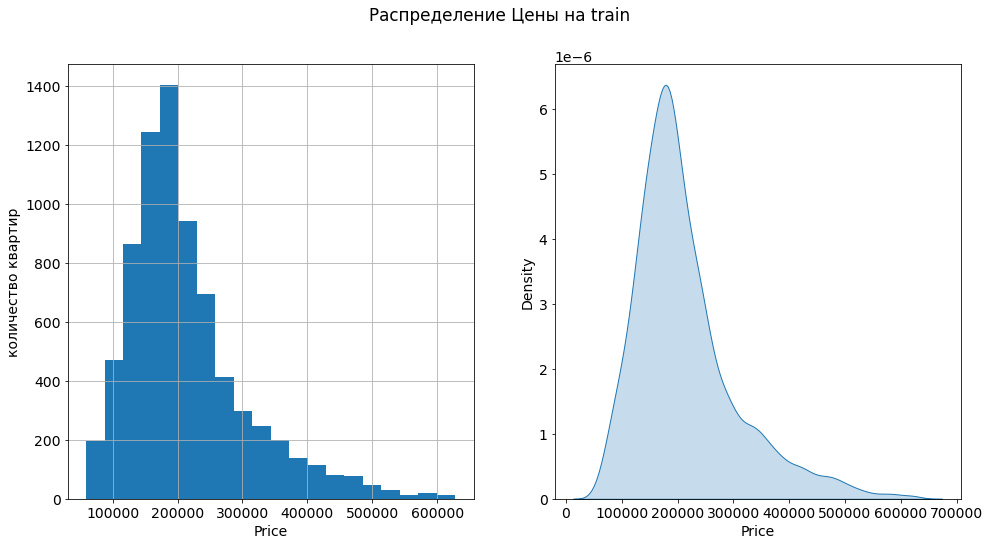

In [127]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
y_train['Price'].hist(density=False, bins=20)
plt.ylabel('количество квартир')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(y_train['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Распределение Цены на train')
plt.show()

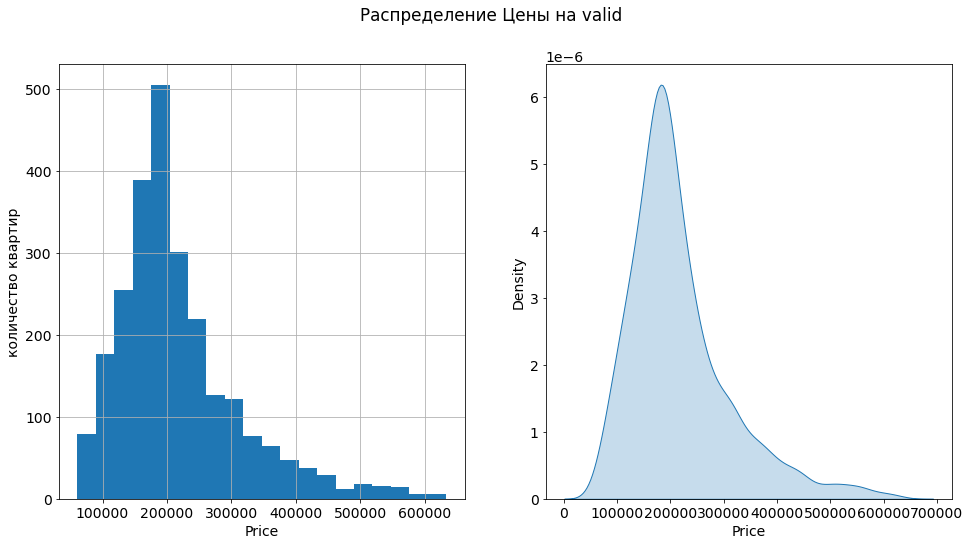

In [128]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
y_valid['Price'].hist(density=False, bins=20)
plt.ylabel('количество квартир')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(y_valid['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Распределение Цены на valid')
plt.show()

In [129]:
target_mean = round(y_train['Price'].mean(), 2)
target_median = y_train['Price'].median()
target_mode = y_train['Price'].mode()[0]
print(f'mean = {target_mean}, median = {target_median}, mode = {target_mode}')

mean = 213250.2, median = 191373.97793199, mode = 59174.77802758122


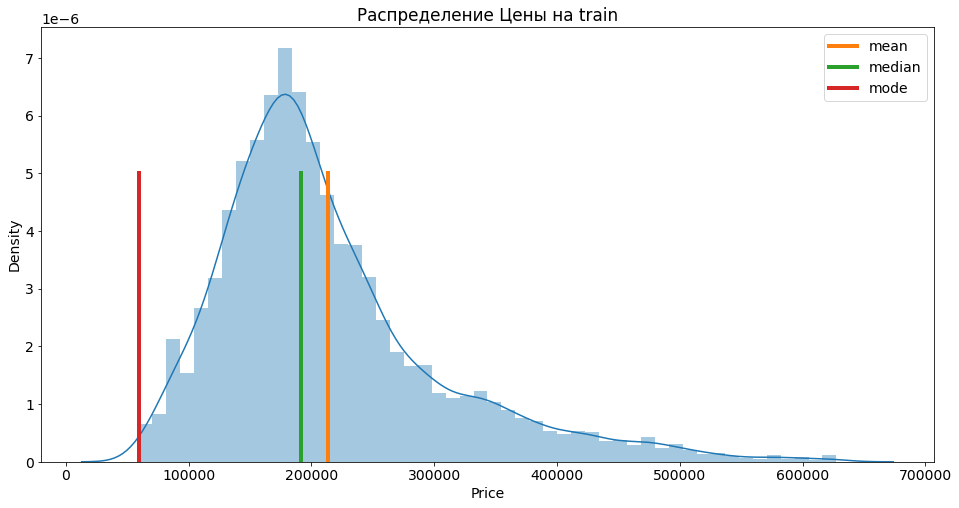

In [130]:
plt.figure(figsize = (16, 8))

sns.distplot(y_train['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Распределение Цены на train')
plt.legend()
plt.show()

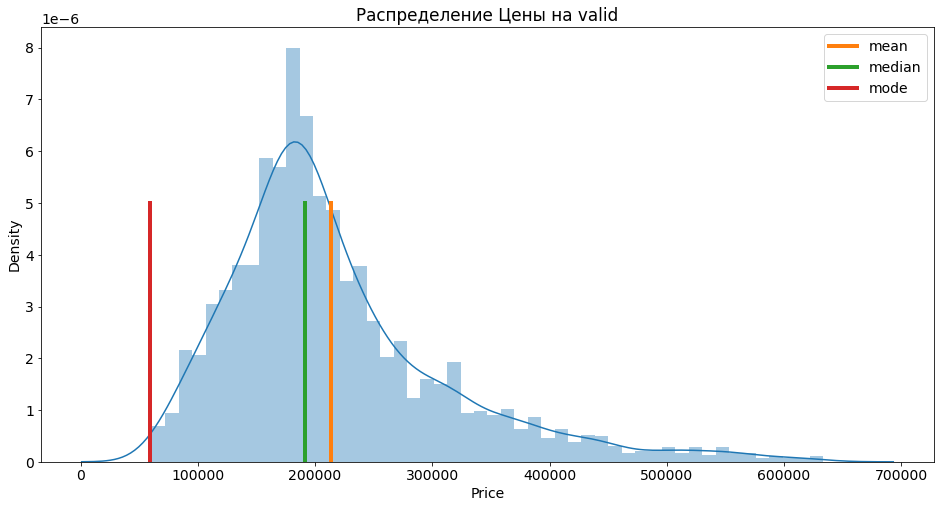

In [131]:
plt.figure(figsize = (16, 8))

sns.distplot(y_valid['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Распределение Цены на valid')
plt.legend()
plt.show()

In [132]:
target_bins = y_train['Price'] // 10000 * 10000

target_adjusted_mode = target_bins.mode()[0]
target_adjusted_mode

180000.0

mean = 213250.2, median = 191373.97793199, mode = 180000.0


<function matplotlib.pyplot.show(close=None, block=None)>

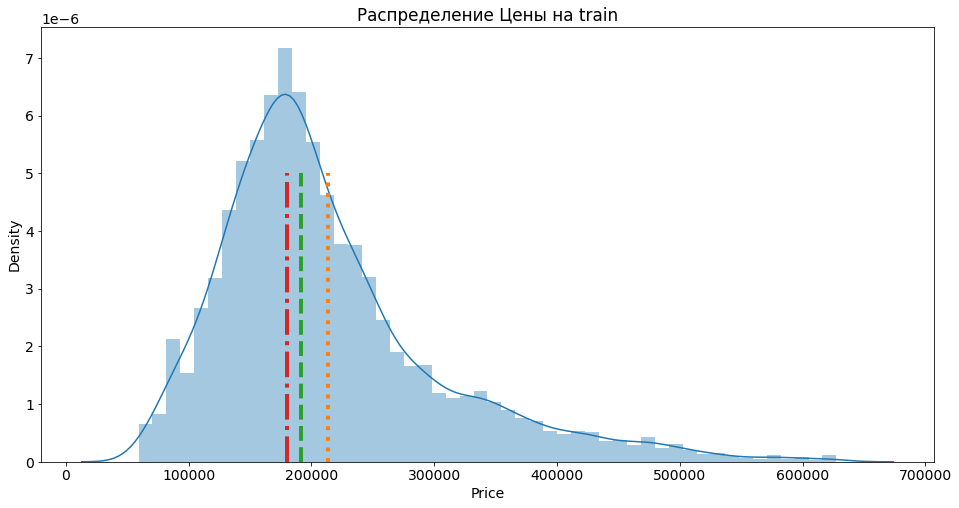

In [133]:
plt.figure(figsize = (16, 8))

sns.distplot(y_train['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_adjusted_mode] * 10, y, label='target_adjusted_mode', linestyle='-.', linewidth=4)
print(f'mean = {target_mean}, median = {target_median}, mode = {target_adjusted_mode}')
plt.title('Распределение Цены на train')
plt.legend
plt.show    

mean = 213250.2, median = 191373.97793199, mode = 180000.0


<function matplotlib.pyplot.show(close=None, block=None)>

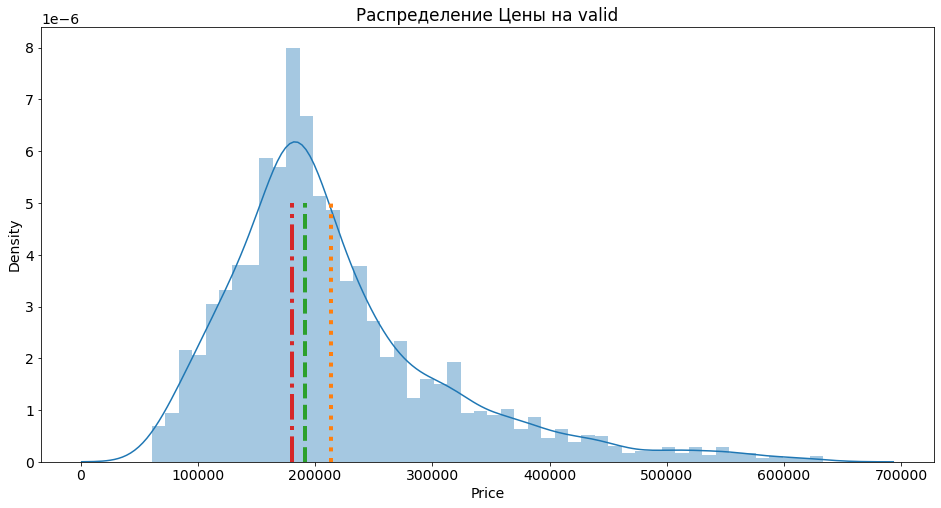

In [134]:
 plt.figure(figsize = (16, 8))

sns.distplot(y_valid['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_adjusted_mode] * 10, y, label='target_adjusted_mode', linestyle='-.', linewidth=4)
print(f'mean = {target_mean}, median = {target_median}, mode = {target_adjusted_mode}')
plt.title('Распределение Цены на valid')
plt.legend
plt.show    

## 7.2 Распределение фичей

## 7.2.1 Количественные признаки

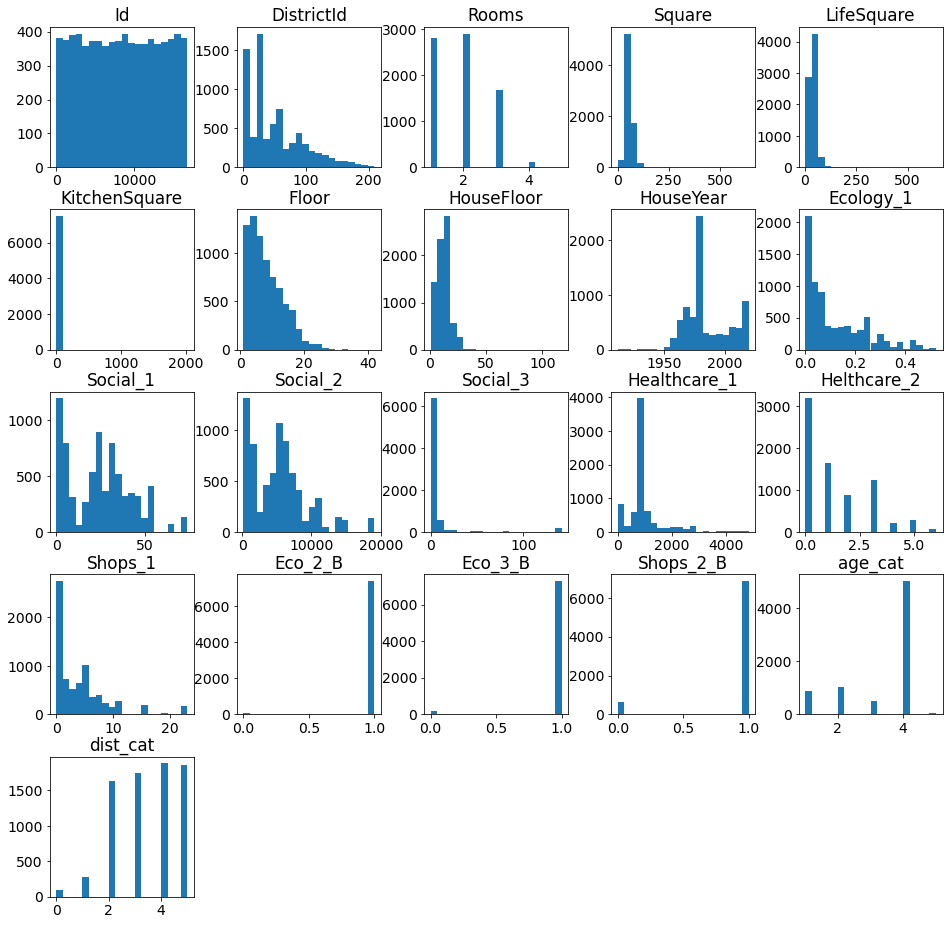

In [135]:
X_train.hist(figsize=(16,16), bins=20, grid=False);

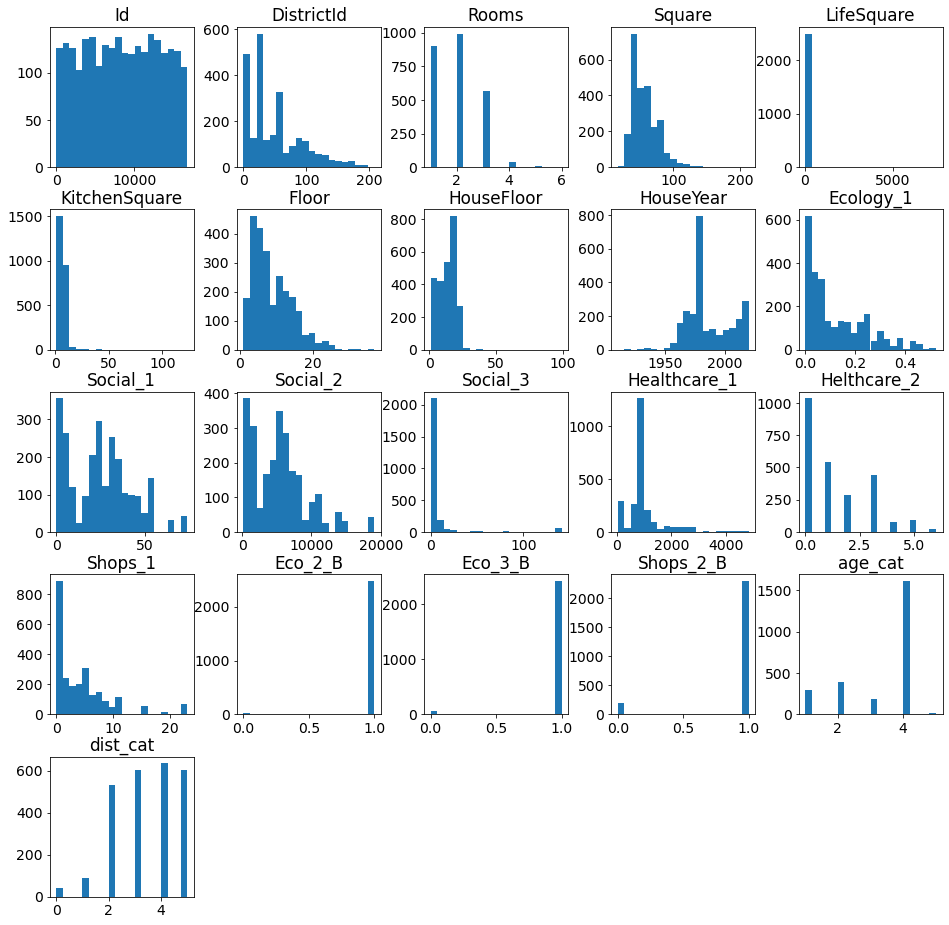

In [136]:
X_valid.hist(figsize=(16,16), bins=20, grid=False);

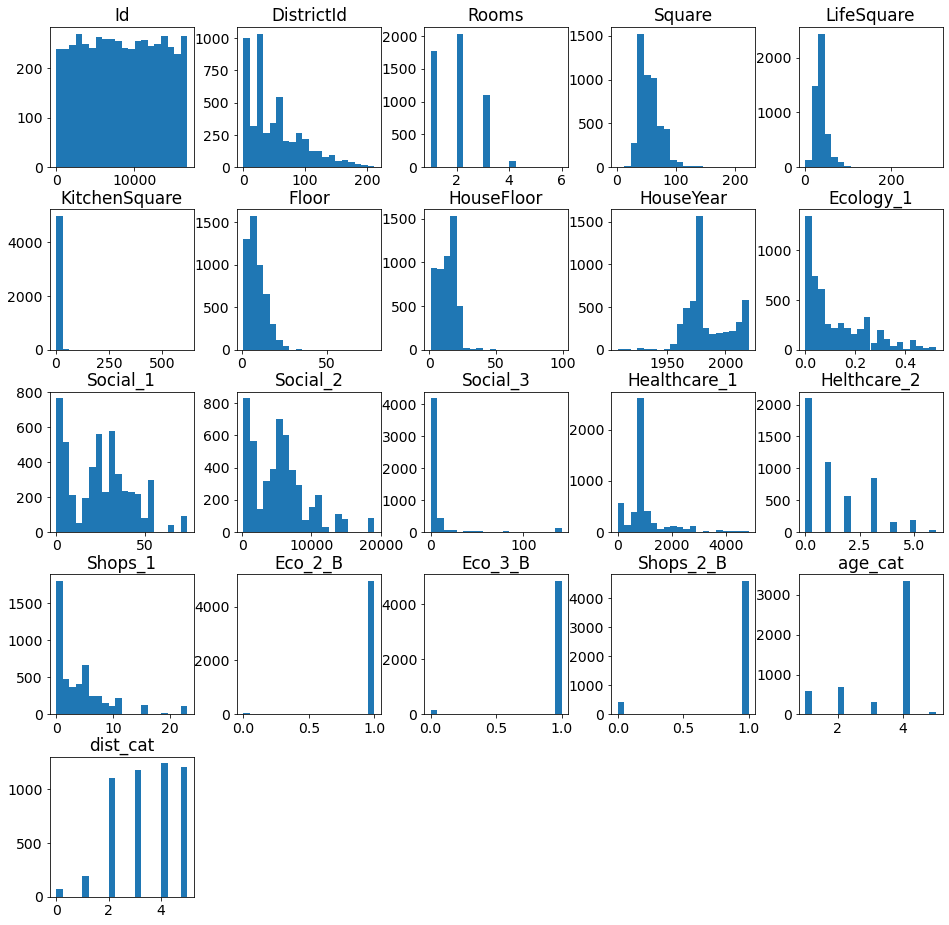

In [137]:
test_df.hist(figsize=(16,16), bins=20, grid=False);

## 7.2.1.1 Обработка признака KitchenSquare

In [138]:
X_train['KitchenSquare'].describe()

count    7500.000000
mean        6.797200
std        32.795894
min         1.000000
25%         3.000000
50%         6.000000
75%         9.000000
max      2014.000000
Name: KitchenSquare, dtype: float64

In [139]:
X_valid['KitchenSquare'].describe()

count    2500.000000
mean        6.374400
std         4.951851
min         1.000000
25%         5.000000
50%         6.000000
75%         9.000000
max       123.000000
Name: KitchenSquare, dtype: float64

In [140]:
test_df['KitchenSquare'].describe()

count    5000.000000
mean        6.378800
std         9.820764
min         1.000000
25%         5.000000
50%         6.000000
75%         9.000000
max       620.000000
Name: KitchenSquare, dtype: float64

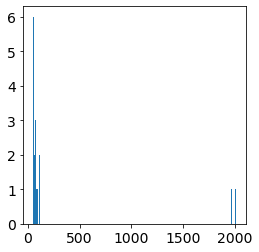

In [141]:
X_train.loc[X_train['KitchenSquare'] > 50, 'KitchenSquare'].\
hist(figsize=(4,4), bins=200, grid=False);

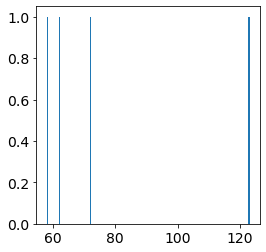

In [142]:
X_valid.loc[X_valid['KitchenSquare'] > 50, 'KitchenSquare'].\
hist(figsize=(4,4), bins=200, grid=False);

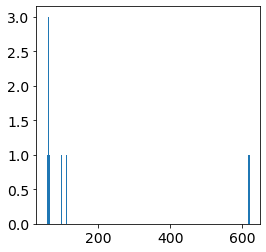

In [143]:
test_df.loc[test_df['KitchenSquare'] > 50, 'KitchenSquare'].\
hist(figsize=(4,4), bins=200, grid=False);

In [144]:
X_train.loc[X_train['KitchenSquare'] > 50, 'KitchenSquare'] = X_train['KitchenSquare'].median()

In [145]:
X_valid.loc[X_valid['KitchenSquare'] > 50, 'KitchenSquare'] = X_train['KitchenSquare'].median()

In [146]:
test_df.loc[test_df['KitchenSquare'] > 50, 'KitchenSquare'] = X_train['KitchenSquare'].median()

In [147]:
X_train.loc[X_train['KitchenSquare'] < 5, 'KitchenSquare'] = X_train['KitchenSquare'].median()

In [148]:
X_valid.loc[X_valid['KitchenSquare'] < 5, 'KitchenSquare'] = X_train['KitchenSquare'].median()

In [149]:
test_df.loc[test_df['KitchenSquare'] < 5, 'KitchenSquare'] = X_train['KitchenSquare'].median()

In [150]:
X_train['KitchenSquare'].describe()

count    7500.000000
mean        7.396533
std         2.511760
min         5.000000
25%         6.000000
50%         6.000000
75%         9.000000
max        48.000000
Name: KitchenSquare, dtype: float64

In [151]:
X_valid['KitchenSquare'].describe()

count    2500.000000
mean        7.456800
std         2.651593
min         5.000000
25%         6.000000
50%         6.000000
75%         9.000000
max        43.000000
Name: KitchenSquare, dtype: float64

In [152]:
test_df['KitchenSquare'].describe()

count    5000.000000
mean        7.370800
std         2.520908
min         5.000000
25%         6.000000
50%         6.000000
75%         9.000000
max        44.000000
Name: KitchenSquare, dtype: float64

## 7.2.1.2 Обработка признака HouseFloor

In [153]:
X_train['HouseFloor'].describe()

count    7500.000000
mean       12.832400
std         6.396512
min         1.000000
25%         9.000000
50%        12.000000
75%        17.000000
max       117.000000
Name: HouseFloor, dtype: float64

In [154]:
X_valid['HouseFloor'].describe()

count    2500.0000
mean       13.2316
std         6.5818
min         1.0000
25%         9.0000
50%        14.0000
75%        17.0000
max        99.0000
Name: HouseFloor, dtype: float64

In [155]:
test_df['HouseFloor'].describe()

count    5000.000000
mean       12.915400
std         6.468617
min         1.000000
25%         9.000000
50%        12.000000
75%        17.000000
max        99.000000
Name: HouseFloor, dtype: float64

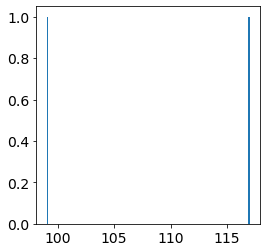

In [156]:
X_train.loc[X_train['HouseFloor'] > 90, 'HouseFloor'].\
hist(figsize=(4,4), bins=200, grid=False);

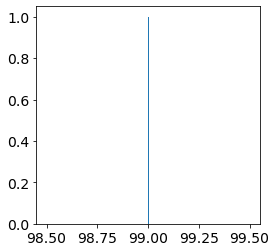

In [157]:
X_valid.loc[X_valid['HouseFloor'] > 90, 'HouseFloor'].\
hist(figsize=(4,4), bins=200, grid=False);

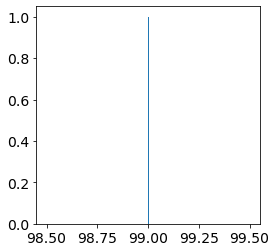

In [158]:
test_df.loc[test_df['HouseFloor'] > 90, 'HouseFloor'].\
hist(figsize=(4,4), bins=200, grid=False);

In [159]:
X_train.loc[X_train['HouseFloor'] > 90, 'HouseFloor'] = X_train['HouseFloor'].median()

In [160]:
X_valid.loc[X_valid['HouseFloor'] > 90, 'HouseFloor'] = X_train['HouseFloor'].median()

In [161]:
test_df.loc[test_df['HouseFloor'] > 90, 'HouseFloor'] = X_train['HouseFloor'].median()

In [162]:
X_train['HouseFloor'].describe()

count    7500.000000
mean       12.806800
std         6.203048
min         1.000000
25%         9.000000
50%        12.000000
75%        17.000000
max        48.000000
Name: HouseFloor, dtype: float64

In [163]:
X_valid['HouseFloor'].describe()

count    2500.000000
mean       13.196800
std         6.354197
min         1.000000
25%         9.000000
50%        14.000000
75%        17.000000
max        44.000000
Name: HouseFloor, dtype: float64

In [164]:
test_df['HouseFloor'].describe()

count    5000.000000
mean       12.898000
std         6.352989
min         1.000000
25%         9.000000
50%        12.000000
75%        17.000000
max        48.000000
Name: HouseFloor, dtype: float64

## 7.2.1.3 Обработка признака LifeSquare

In [165]:
X_train['LifeSquare'].describe()

count    7500.000000
mean       35.296254
std        17.800186
min         0.370619
25%        25.207291
50%        32.641537
75%        41.278427
max       638.163193
Name: LifeSquare, dtype: float64

In [166]:
X_valid['LifeSquare'].describe()

count    2500.000000
mean       39.057304
std       150.076087
min         0.795539
25%        26.813135
50%        32.641537
75%        41.812510
max      7480.592129
Name: LifeSquare, dtype: float64

In [167]:
test_df['LifeSquare'].describe()

count    5000.000000
mean       35.426514
std        15.925257
min         0.333490
25%        25.850152
50%        32.641537
75%        41.769526
max       303.071094
Name: LifeSquare, dtype: float64

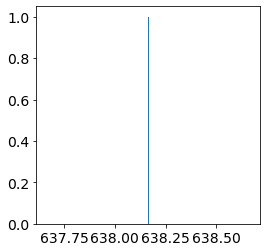

In [168]:
X_train.loc[X_train['LifeSquare'] > 500, 'LifeSquare'].\
hist(figsize=(4,4), bins=200, grid=False);

In [169]:
X_train.loc[X_train['LifeSquare'] > 500, 'LifeSquare'] = X_train['LifeSquare'].median()
X_valid.loc[X_valid['LifeSquare'] > 500, 'LifeSquare'] = X_train['LifeSquare'].median()
test_df.loc[test_df['LifeSquare'] > 500, 'LifeSquare'] = X_train['LifeSquare'].median()

In [170]:
X_train.loc[X_train['LifeSquare'] < 5, 'LifeSquare'] = X_train['LifeSquare'].median()
X_valid.loc[X_valid['LifeSquare'] < 5, 'LifeSquare'] = X_train['LifeSquare'].median()
test_df.loc[test_df['LifeSquare'] < 5, 'LifeSquare'] = X_train['LifeSquare'].median()

In [171]:
X_train['LifeSquare'].describe()

count    7500.000000
mean       35.686558
std        15.865549
min         5.061446
25%        26.925479
50%        32.641537
75%        41.267071
max       410.639749
Name: LifeSquare, dtype: float64

In [172]:
X_valid['LifeSquare'].describe()

count    2500.000000
mean       36.590357
std        18.315645
min         5.005477
25%        28.228845
50%        32.641537
75%        41.793816
max       461.463614
Name: LifeSquare, dtype: float64

In [173]:
test_df['LifeSquare'].describe()

count    5000.000000
mean       35.935123
std        15.338858
min         5.042692
25%        27.638027
50%        32.641537
75%        41.769526
max       303.071094
Name: LifeSquare, dtype: float64

## 7.2.1.4 Обработка признака Square

In [174]:
X_train['Square'].describe()

count    7500.000000
mean       56.123610
std        21.537311
min         1.136859
25%        41.665903
50%        52.328644
75%        65.745649
max       641.065193
Name: Square, dtype: float64

In [175]:
X_valid['Square'].describe()

count    2500.000000
mean       56.892270
std        19.545621
min        16.547242
25%        42.011032
50%        53.096580
75%        66.520001
max       212.932361
Name: Square, dtype: float64

In [176]:
test_df['Square'].describe()

count    5000.000000
mean       56.449500
std        19.092787
min         1.378543
25%        41.906231
50%        52.921340
75%        66.285129
max       223.453689
Name: Square, dtype: float64

In [177]:
X_train.loc[X_train['Square'] < 10, 'Square'] = X_train['Square'].median()

In [178]:
X_valid.loc[X_valid['Square'] < 10, 'Square'] = X_train['Square'].median()

In [179]:
test_df.loc[test_df['Square'] < 10, 'Square'] = X_train['Square'].median()

In [180]:
X_train.loc[X_train['Square'] > 500, 'Square'] = X_train['Square'].median()

In [181]:
X_valid.loc[X_valid['Square'] > 500, 'Square'] = X_train['Square'].median()

In [182]:
test_df.loc[test_df['Square'] > 500, 'Square'] = X_train['Square'].median()

## 7.2.1.5 Отображение признаков на графиках

<function matplotlib.pyplot.show(close=None, block=None)>

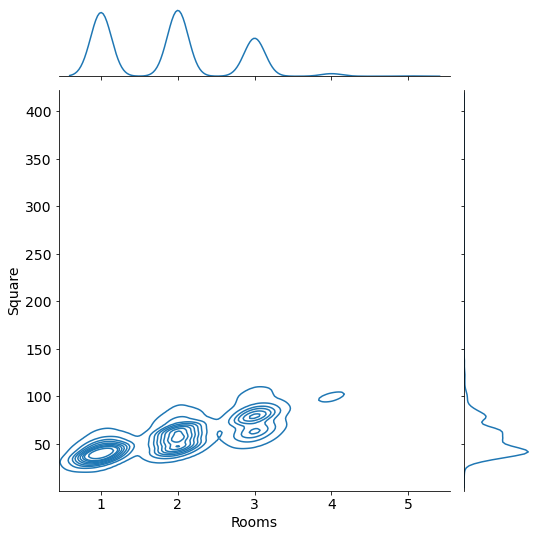

In [183]:
grid = sns.jointplot(X_train['Rooms'], X_train['Square'], kind='kde')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show

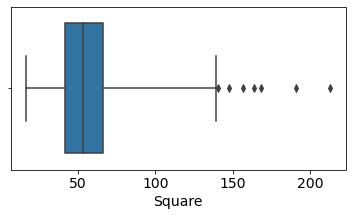

In [184]:
plt.figure(figsize=(6,3))

sns.boxplot(X_valid['Square'], whis=3)

plt.xlabel('Square')
plt.show()

## 7.2.1.6 Обработка признаков Square < LifeSquare

In [185]:
X_train[(X_train['Square'] < X_train['LifeSquare'])].head(1000)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat,dist_cat
5165,4678,44,1,52.422475,52.549463,6.0,12,19,2016,0.036122,...,4378,0,1036.0,1,1,1,1,1,1,3
2564,6279,27,1,40.907292,42.102736,6.0,17,16,2017,0.011654,...,915,0,900.0,0,0,1,1,1,1,4
8687,6874,53,1,38.751591,39.703850,6.0,5,18,2017,0.049637,...,7759,0,229.0,1,3,1,1,1,1,3
7774,13942,63,1,48.104035,48.705442,10.0,13,17,2016,0.238617,...,3889,6,705.0,3,6,1,1,1,1,3
4382,5421,74,2,81.046411,83.259988,11.0,16,22,2019,0.075779,...,1437,3,900.0,0,2,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,3992,1,3,87.200625,87.730225,6.0,21,22,1977,0.007122,...,264,0,900.0,0,1,1,1,1,4,5
7208,15523,63,1,49.039357,50.957360,10.0,19,25,2018,0.238617,...,3889,6,705.0,3,6,1,1,1,1,3
7099,15758,45,3,70.409984,72.588205,8.0,8,9,1975,0.014423,...,3806,4,900.0,0,3,1,1,1,4,3
1528,2137,9,2,46.469859,50.703196,9.0,2,12,1966,0.310199,...,2748,1,900.0,0,0,1,1,1,4,5


In [186]:
X_valid[(X_valid['Square'] < X_valid['LifeSquare'])].head(1000)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat,dist_cat
9485,7198,48,2,80.294115,81.452946,6.0,21,12,1977,0.041125,...,9515,5,900.0,1,10,1,1,1,4,3
4949,12330,74,2,78.922350,79.811358,6.0,9,1,2016,0.075779,...,1437,3,900.0,0,2,1,1,1,1,0
8328,4127,27,1,44.383976,46.958655,6.0,4,22,2017,0.211401,...,1892,0,900.0,0,1,1,1,1,1,4
5547,16209,6,3,77.341477,80.610702,6.0,7,17,1977,0.243205,...,1564,0,540.0,0,0,1,1,1,4,5
9655,12692,27,2,86.036862,88.541965,6.0,3,22,1977,0.072158,...,629,1,900.0,0,0,1,1,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7319,5616,85,3,105.443592,107.927859,15.0,11,12,1977,0.072158,...,629,1,900.0,0,0,1,1,0,4,2
9130,1915,30,2,68.752862,69.521068,6.0,2,1,1977,0.000078,...,6398,141,1046.0,3,23,1,1,1,4,4
834,892,74,1,48.166394,50.044329,6.0,3,16,2018,0.075779,...,1437,3,900.0,0,2,1,1,1,1,0
8171,3470,134,1,40.045620,41.798216,6.0,8,17,1977,0.212515,...,3293,16,628.0,3,7,1,1,1,4,2


In [187]:
test_df[(test_df['Square'] < test_df['LifeSquare'])].head(1000)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat,dist_cat
1,5925,62,1,42.493907,42.568133,10.0,7,17,2017,0.072158,...,629,1,900.0,0,0,1,1,0,1,3
25,14686,1,3,77.229885,79.958685,6.0,18,17,1977,0.007122,...,264,0,900.0,0,1,1,1,1,4,5
28,10869,23,3,78.001888,82.566322,6.0,21,25,2015,0.075779,...,1437,3,900.0,0,2,1,1,1,1,4
39,16384,1,2,52.773671,52.910722,10.0,6,17,2017,0.007122,...,264,0,900.0,0,1,1,1,1,1,5
41,13151,25,1,29.249108,32.641537,6.0,22,25,2016,0.069753,...,13670,4,900.0,1,11,1,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898,15984,23,3,104.786355,106.730272,6.0,14,25,1977,0.075779,...,1437,3,900.0,0,2,1,1,1,4,4
4945,9888,45,2,60.501260,60.881119,10.0,24,24,2016,0.195781,...,5212,6,900.0,3,2,1,1,1,1,3
4970,13494,169,1,47.012027,47.372332,8.0,4,17,2019,0.178917,...,3594,4,192.0,1,5,1,1,1,1,1
4979,4821,74,2,82.542507,82.585069,6.0,4,17,2015,0.309479,...,7715,4,990.0,0,6,1,1,1,1,0


In [188]:
X_train.loc[X_train['Square'] < X_train['LifeSquare'], ['Square', 'LifeSquare']] = X_train.loc[X_train['Square'] < X_train['LifeSquare'], ['LifeSquare', 'Square']].values

In [189]:
X_valid.loc[X_valid['Square'] < X_valid['LifeSquare'], ['Square', 'LifeSquare']] = X_valid.loc[X_valid['Square'] < X_valid['LifeSquare'], ['LifeSquare', 'Square']].values

In [190]:
test_df.loc[test_df['Square'] < test_df['LifeSquare'], ['Square', 'LifeSquare']] = test_df.loc[test_df['Square'] < test_df['LifeSquare'], ['LifeSquare', 'Square']].values

In [191]:
X_train.loc[7246, :]

Id               7026.000000
DistrictId         62.000000
Rooms               1.000000
Square             46.759316
LifeSquare         44.019287
KitchenSquare       6.000000
Floor               7.000000
HouseFloor         12.000000
HouseYear        2020.000000
Ecology_1           0.072158
Social_1            2.000000
Social_2          629.000000
Social_3            1.000000
Healthcare_1      900.000000
Helthcare_2         0.000000
Shops_1             0.000000
Eco_2_B             1.000000
Eco_3_B             1.000000
Shops_2_B           0.000000
age_cat             1.000000
dist_cat            3.000000
Name: 7246, dtype: float64

## 7.2.1.7 Обработка признаков Square < (LifeSquare + KitchenSquare)

In [192]:
X_train[(X_train['Square'] < (X_train['LifeSquare'] + X_train['KitchenSquare']))].head(1000)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat,dist_cat
9805,1644,6,1,39.147138,38.473125,6.0,17,17,2017,0.243205,...,1564,0,540.0,0,0,1,1,1,1,5
5165,4678,44,1,52.549463,52.422475,6.0,12,19,2016,0.036122,...,4378,0,1036.0,1,1,1,1,1,1,3
2564,6279,27,1,42.102736,40.907292,6.0,17,16,2017,0.011654,...,915,0,900.0,0,0,1,1,1,1,4
9714,14021,1,2,65.005981,64.549392,6.0,16,20,1977,0.007122,...,264,0,900.0,0,1,1,1,1,4,5
2848,13099,27,1,37.722975,32.641537,6.0,16,22,1977,0.211401,...,1892,0,900.0,0,1,1,1,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998,5080,9,2,53.788536,51.907937,6.0,1,1,1977,0.161532,...,5648,1,30.0,2,4,1,1,1,4,5
663,5749,48,3,96.706813,96.286194,10.0,14,20,2015,0.041125,...,9515,5,900.0,1,10,1,1,1,1,3
5864,9813,1,3,87.588288,84.910535,6.0,17,17,1977,0.007122,...,264,0,900.0,0,1,1,1,1,4,5
1306,11210,27,2,68.453814,66.918934,6.0,15,17,1977,0.017647,...,469,0,900.0,0,0,1,1,1,4,4


In [193]:
X_valid[(X_valid['Square'] < (X_valid['LifeSquare'] + X_valid['KitchenSquare']))].head(1000)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat,dist_cat
6252,3367,3,3,101.862701,99.970065,11.0,7,15,2013,0.050900,...,10621,1,30.0,2,3,1,1,1,2,5
9485,7198,48,2,81.452946,80.294115,6.0,21,12,1977,0.041125,...,9515,5,900.0,1,10,1,1,1,4,3
2678,7882,62,1,45.573548,44.462279,6.0,4,17,2015,0.072158,...,629,1,900.0,0,0,1,1,0,1,3
4949,12330,74,2,79.811358,78.922350,6.0,9,1,2016,0.075779,...,1437,3,900.0,0,2,1,1,1,1,0
8328,4127,27,1,46.958655,44.383976,6.0,4,22,2017,0.211401,...,1892,0,900.0,0,1,1,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8534,12573,6,1,42.544886,41.675842,10.0,6,17,2015,0.243205,...,1564,0,540.0,0,0,1,1,1,1,5
8043,8308,27,1,42.475577,32.641537,10.0,12,20,1977,0.011654,...,915,0,900.0,0,0,1,1,1,4,4
868,2159,30,1,33.227093,32.639166,6.0,4,4,2016,0.000078,...,6398,141,1046.0,3,23,1,1,1,1,4
7272,16504,27,1,72.486741,58.944462,20.0,6,6,2017,0.075424,...,3097,0,900.0,0,0,1,1,1,1,4


In [194]:
test_df[(test_df['Square'] < (test_df['LifeSquare'] + test_df['KitchenSquare']))].head(1000)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat,dist_cat
1,5925,62,1,42.568133,42.493907,10.0,7,17,2017,0.072158,...,629,1,900.0,0,0,1,1,0,1,3
9,8354,62,2,62.593787,59.786844,10.0,1,16,1981,0.002212,...,7614,3,900.0,1,5,1,1,0,4,3
22,15709,48,3,86.489935,86.165023,6.0,24,1,2015,0.041125,...,9515,5,900.0,1,10,1,1,1,1,3
25,14686,1,3,79.958685,77.229885,6.0,18,17,1977,0.007122,...,264,0,900.0,0,1,1,1,1,4,5
28,10869,23,3,82.566322,78.001888,6.0,21,25,2015,0.075779,...,1437,3,900.0,0,2,1,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,14793,27,1,47.295978,45.000047,10.0,6,5,2017,0.072158,...,629,1,900.0,0,0,1,1,0,1,4
4979,4821,74,2,82.585069,82.542507,6.0,4,17,2015,0.309479,...,7715,4,990.0,0,6,1,1,1,1,0
4983,9519,62,3,81.912997,75.872094,11.0,3,6,2015,0.072158,...,629,1,900.0,0,0,1,1,0,1,3
4994,13060,25,2,51.144906,48.979540,6.0,18,25,2015,0.069753,...,13670,4,900.0,1,11,1,1,1,1,4


In [195]:
X_train.loc[X_train['Square'] < (X_train['LifeSquare'] + X_train['KitchenSquare']), 'Square'] = X_train.loc[X_train['Square'] < (X_train['LifeSquare'] + X_train['KitchenSquare']), ['LifeSquare', 'KitchenSquare']].sum(axis=1)

In [196]:
X_train.loc[7246, :]

Id               7026.000000
DistrictId         62.000000
Rooms               1.000000
Square             50.019287
LifeSquare         44.019287
KitchenSquare       6.000000
Floor               7.000000
HouseFloor         12.000000
HouseYear        2020.000000
Ecology_1           0.072158
Social_1            2.000000
Social_2          629.000000
Social_3            1.000000
Healthcare_1      900.000000
Helthcare_2         0.000000
Shops_1             0.000000
Eco_2_B             1.000000
Eco_3_B             1.000000
Shops_2_B           0.000000
age_cat             1.000000
dist_cat            3.000000
Name: 7246, dtype: float64

In [197]:
X_valid.loc[X_valid['Square'] < (X_valid['LifeSquare'] + X_valid['KitchenSquare']), 'Square'] = X_valid.loc[X_valid['Square'] < (X_valid['LifeSquare'] + X_valid['KitchenSquare']), ['LifeSquare', 'KitchenSquare']].sum(axis=1)

In [198]:
X_valid.loc[8296, :]

Id               8832.000000
DistrictId          1.000000
Rooms               3.000000
Square             85.438325
LifeSquare         79.438325
KitchenSquare       6.000000
Floor              15.000000
HouseFloor         21.000000
HouseYear        2020.000000
Ecology_1           0.007122
Social_1            1.000000
Social_2          264.000000
Social_3            0.000000
Healthcare_1      900.000000
Helthcare_2         0.000000
Shops_1             1.000000
Eco_2_B             1.000000
Eco_3_B             1.000000
Shops_2_B           1.000000
age_cat             1.000000
dist_cat            5.000000
Name: 8296, dtype: float64

In [199]:
test_df.loc[test_df['Square'] < (test_df['LifeSquare'] + test_df['KitchenSquare']), 'Square'] = test_df.loc[test_df['Square'] < (test_df['LifeSquare'] + test_df['KitchenSquare']), ['LifeSquare', 'KitchenSquare']].sum(axis=1)

In [200]:
test_df.loc[468, :]

Id               1276.000000
DistrictId         23.000000
Rooms               2.000000
Square             57.640968
LifeSquare         51.640968
KitchenSquare       6.000000
Floor               5.000000
HouseFloor          3.000000
HouseYear        2020.000000
Ecology_1           0.005767
Social_1            1.000000
Social_2          388.000000
Social_3            0.000000
Healthcare_1      900.000000
Helthcare_2         0.000000
Shops_1             0.000000
Eco_2_B             1.000000
Eco_3_B             1.000000
Shops_2_B           1.000000
age_cat             1.000000
dist_cat            4.000000
Name: 468, dtype: float64

## 7.2.1.8 Обработка признаков Floor > HouseFloor

In [201]:
X_train[(X_train['HouseFloor'] < X_train['Floor'])].head(1000)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat,dist_cat
2564,6279,27,1,46.907292,40.907292,6.0,17,16,2017,0.011654,...,915,0,900.0,0,0,1,1,1,1,4
3026,12229,180,2,76.083312,48.026246,14.0,6,5,1918,0.037316,...,6748,93,562.0,4,10,1,1,1,5,1
3207,8511,21,3,59.101258,40.219586,5.0,6,5,1958,0.034331,...,5487,3,900.0,0,4,1,1,1,4,4
9292,15075,54,2,81.220434,32.641537,6.0,12,1,2016,0.006076,...,5285,0,645.0,6,6,1,1,1,1,3
87,12537,1,1,45.734439,32.641537,6.0,21,4,1977,0.007122,...,264,0,900.0,0,1,1,1,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3591,3688,74,2,86.969441,32.641537,6.0,2,1,1977,0.075779,...,1437,3,900.0,0,2,1,1,1,4,0
3714,2331,25,2,59.503491,32.641537,6.0,22,1,1977,0.069753,...,13670,4,900.0,1,11,1,1,1,4,4
1394,10953,27,1,58.408027,52.408027,6.0,5,4,1977,0.072158,...,629,1,900.0,0,0,1,1,0,4,4
5631,716,113,3,144.287183,125.287183,19.0,26,24,2017,0.050756,...,5469,1,145.0,0,1,1,1,1,1,2


In [202]:
X_valid[(X_valid['HouseFloor'] < X_valid['Floor'])].head(1000)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat,dist_cat
4684,13670,22,1,87.485627,32.641537,6.0,16,12,1977,0.118537,...,6207,1,1183.0,1,0,1,1,1,4,4
439,129,60,1,34.491039,18.042006,6.0,6,5,1964,0.341072,...,5664,48,2300.0,3,11,1,1,1,4,3
582,7804,63,4,95.087475,72.758966,10.0,7,5,1957,0.238617,...,3889,6,705.0,3,6,1,1,1,4,3
9930,3659,27,2,56.812696,32.641537,6.0,11,9,1977,0.211401,...,1892,0,900.0,0,1,1,1,1,4,4
9896,293,2,3,88.069327,59.756576,8.0,6,5,1955,0.035145,...,9292,3,2620.0,0,3,1,1,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4127,8243,21,2,45.924009,27.066626,6.0,7,5,1961,0.034331,...,5487,3,900.0,0,4,1,1,1,4,4
8617,9466,16,3,53.274171,38.122685,6.0,11,9,1978,0.037178,...,11217,1,2300.0,1,7,1,1,1,4,5
5780,3066,160,2,48.047338,28.005250,6.0,10,9,1977,0.000000,...,8647,0,810.0,0,5,1,1,1,4,1
6752,3907,6,2,52.747438,32.641537,6.0,9,1,1977,0.243205,...,1564,0,540.0,0,0,1,1,1,4,5


In [203]:
test_df[(test_df['HouseFloor'] < test_df['Floor'])].head(1000)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat,dist_cat
11,13270,9,3,80.599472,32.641537,6.0,4,1,1977,0.161532,...,5648,1,30.0,2,4,1,1,1,4,5
12,5250,96,4,87.776382,54.620540,10.0,25,24,2014,0.041116,...,14892,4,900.0,1,4,1,1,1,2,2
14,11404,27,1,44.415510,32.641537,6.0,14,1,1977,0.072158,...,629,1,900.0,0,0,1,1,0,4,4
21,3190,9,2,64.862396,32.641537,6.0,7,1,1977,0.161532,...,5648,1,30.0,2,4,1,1,1,4,5
22,15709,48,3,92.165023,86.165023,6.0,24,1,2015,0.041125,...,9515,5,900.0,1,10,1,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,14793,27,1,55.000047,45.000047,10.0,6,5,2017,0.072158,...,629,1,900.0,0,0,1,1,0,1,4
4978,15243,53,2,56.872925,32.641537,6.0,20,12,1977,0.049637,...,7759,0,229.0,1,3,1,1,1,4,3
4980,11709,63,1,51.872447,32.641537,6.0,23,22,2016,0.238617,...,3889,6,705.0,3,6,1,1,1,1,3
4982,8197,9,1,38.595211,22.895884,8.0,19,17,1992,0.161532,...,5648,1,30.0,2,4,1,1,1,3,5


In [204]:
X_train.loc[X_train['HouseFloor'] < X_train['Floor'], ['HouseFloor', 'Floor']] = X_train.loc[X_train['HouseFloor'] < X_train['Floor'], ['Floor', 'HouseFloor']].values

In [205]:
X_valid.loc[X_valid['HouseFloor'] < X_valid['Floor'], ['HouseFloor', 'Floor']] = X_valid.loc[X_valid['HouseFloor'] < X_valid['Floor'], ['Floor', 'HouseFloor']].values

In [206]:
test_df.loc[test_df['HouseFloor'] < test_df['Floor'], ['HouseFloor', 'Floor']] = test_df.loc[test_df['HouseFloor'] < test_df['Floor'], ['Floor', 'HouseFloor']].values

In [207]:
test_df.loc[468, :]

Id               1276.000000
DistrictId         23.000000
Rooms               2.000000
Square             57.640968
LifeSquare         51.640968
KitchenSquare       6.000000
Floor               3.000000
HouseFloor          5.000000
HouseYear        2020.000000
Ecology_1           0.005767
Social_1            1.000000
Social_2          388.000000
Social_3            0.000000
Healthcare_1      900.000000
Helthcare_2         0.000000
Shops_1             0.000000
Eco_2_B             1.000000
Eco_3_B             1.000000
Shops_2_B           1.000000
age_cat             1.000000
dist_cat            4.000000
Name: 468, dtype: float64

## 7.2.2 Категориальные признаки

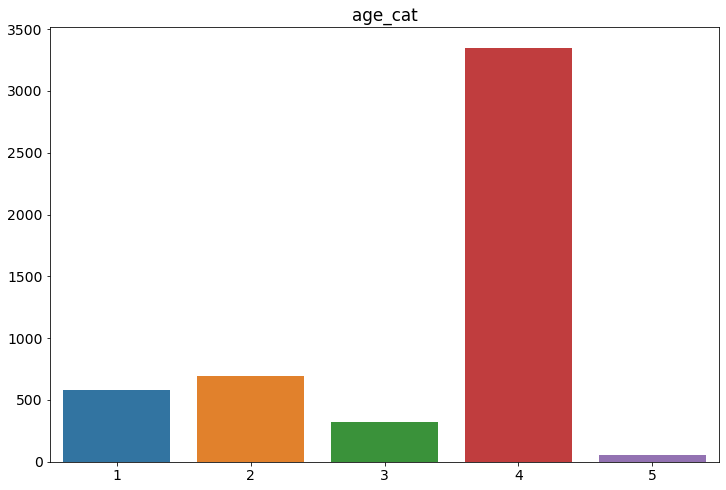

In [208]:
counts = test_df['age_cat'].value_counts()

plt.figure(figsize=(12, 8))
plt.title('age_cat')
sns.barplot(counts.index, counts.values)

plt.show()

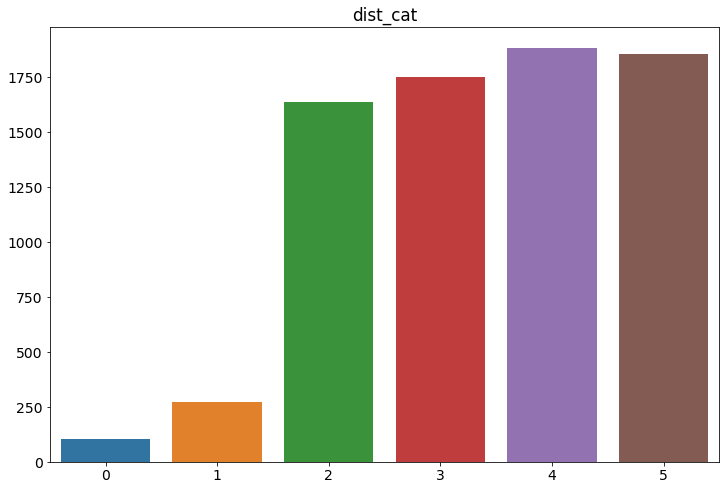

In [209]:
counts_ = X_train['dist_cat'].value_counts()

plt.figure(figsize=(12, 8))
plt.title('dist_cat')
sns.barplot(counts_.index, counts_.values)

plt.show()

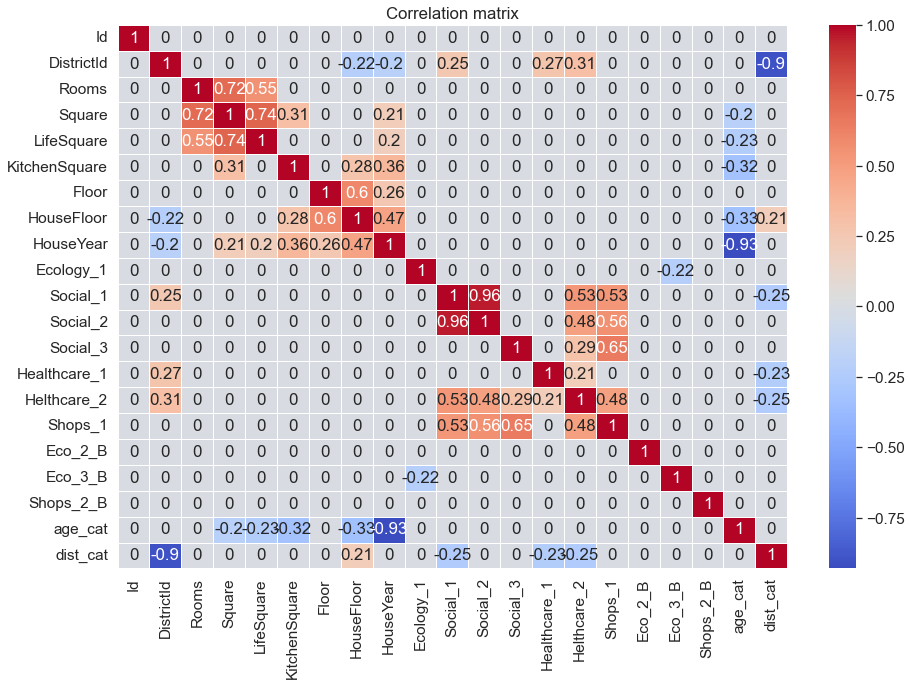

In [210]:
plt.figure(figsize = (15, 10))

sns.set(font_scale=1.4)

corr_matrix = X_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

## 7.3 Удаление Id

In [211]:
X_train = X_train.drop('Id', axis=1)

In [212]:
X_valid = X_valid.drop('Id', axis=1)

In [213]:
test_df = test_df.drop('Id', axis=1)

In [214]:
X_train.head(20)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat,dist_cat
4901,99,2,57.352825,36.375196,9.0,8,14,1998,3.349371e-02,66,10573,1,1322.0,3,8,1,1,1,3,2
4375,48,3,79.705401,47.831885,10.0,15,17,1984,4.112463e-02,46,9515,5,900.0,1,10,1,1,1,4,3
6698,150,2,47.230717,30.442536,6.0,10,12,1971,2.074133e-02,24,5613,5,1340.0,2,5,1,1,1,4,1
9805,6,1,44.473125,38.473125,6.0,17,17,2017,2.432045e-01,5,1564,0,540.0,0,0,1,1,1,1,5
1101,4,2,45.595236,29.986188,5.0,5,5,1961,4.203159e-02,37,6856,84,1940.0,2,5,1,1,1,4,5
9537,23,1,39.067843,32.641537,6.0,16,17,1977,7.577876e-02,6,1437,3,900.0,0,2,1,1,1,4,4
7655,68,2,49.932152,30.017542,6.0,11,12,1972,0.000000e+00,33,7425,1,900.0,2,5,1,1,1,4,3
5235,199,3,71.109206,36.527485,13.0,4,11,1962,1.800000e-09,16,3681,73,1815.0,2,5,1,1,1,4,1
5165,44,1,58.422475,52.422475,6.0,12,19,2016,3.612229e-02,24,4378,0,1036.0,1,1,1,1,1,1,3
118,85,3,72.120067,47.896262,10.0,9,16,1982,3.717782e-02,52,11217,1,2300.0,1,7,1,1,1,4,2


In [215]:
X_valid.head(20)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat,dist_cat
6252,3,3,110.970065,99.970065,11.0,7,15,2013,0.050900,43,10621,1,30.0,2,3,1,1,1,2,5
4684,22,1,87.485627,32.641537,6.0,12,16,1977,0.118537,30,6207,1,1183.0,1,0,1,1,1,4,4
1731,152,2,40.649901,22.288673,7.0,6,9,1964,0.042032,37,6856,84,1940.0,2,5,1,1,1,4,1
4742,41,1,42.909800,20.923332,9.0,14,16,1980,0.175055,36,10055,3,900.0,1,0,1,1,1,4,3
4521,53,1,35.108196,22.155378,9.0,5,12,1967,0.049637,34,7759,0,229.0,1,3,1,1,1,4,3
6340,11,2,59.634032,33.268792,9.0,7,13,2015,0.038693,28,6533,1,1015.0,2,5,1,1,1,1,5
576,59,2,61.142882,36.913778,10.0,15,17,1988,0.019509,37,7687,11,176.0,5,5,1,1,1,4,3
5202,52,1,42.191653,22.235533,7.0,15,17,2007,0.371149,34,7065,1,750.0,2,5,1,1,1,2,3
6363,6,2,62.000239,32.641537,6.0,12,17,2014,0.243205,5,1564,0,540.0,0,0,1,1,1,2,5
439,60,1,34.491039,18.042006,6.0,5,6,1964,0.341072,27,5664,48,2300.0,3,11,1,1,1,4,3


In [216]:
test_df.head(20)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat,dist_cat
0,44,1,36.847630,19.094182,5.0,5,9,1970,0.036122,24,4378,0,1036.0,1,1,1,1,1,4,3
1,62,1,52.493907,42.493907,10.0,7,17,2017,0.072158,2,629,1,900.0,0,0,1,1,0,1,3
2,27,2,59.463678,32.641537,9.0,19,19,1977,0.211401,9,1892,0,900.0,0,1,1,1,1,4,4
3,23,3,49.646030,33.893825,6.0,2,2,1965,0.014073,2,475,0,900.0,0,0,1,1,1,4,4
4,74,1,53.837056,32.641537,6.0,8,17,1977,0.309479,35,7715,4,990.0,0,6,1,1,1,4,0
5,38,3,87.139994,53.180419,10.0,4,23,2011,0.060753,15,2787,2,520.0,0,7,1,1,1,2,3
6,62,1,46.269456,22.820239,11.0,8,17,2014,0.072158,2,629,1,900.0,0,0,1,1,0,2,3
7,2,2,48.172969,29.924204,6.0,4,9,1974,0.000000,33,7425,1,900.0,2,5,1,1,1,4,5
8,1,1,43.153761,21.017596,9.0,10,17,2014,0.007122,1,264,0,900.0,0,1,1,1,1,2,5
9,62,2,69.786844,59.786844,10.0,1,16,1981,0.002212,39,7614,3,900.0,1,5,1,1,0,4,3


In [217]:
y_train.head(20)

,Price
4901,219547.192912
4375,346649.424867
6698,205517.003027
9805,126266.883896
1101,260449.038197
9537,125097.297255
7655,248608.068246
5235,432546.129741
5165,262758.845846
118,290525.223574


## 8. Масштабирование

In [218]:
from sklearn.preprocessing import RobustScaler

In [219]:
cols_for_scale = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1',
       'Eco_2_B', 'Eco_3_B', 'Shops_2_B', 'age_cat', 'dist_cat']

In [220]:
scaler = RobustScaler()

In [221]:
X_train[cols_for_scale] = scaler.fit_transform(X_train[cols_for_scale])

In [222]:
X_valid[cols_for_scale] = scaler.transform(X_valid[cols_for_scale])

In [223]:
test_df[cols_for_scale] = scaler.transform(test_df[cols_for_scale])

## 9. Построение модели

## 9.1 Обучение модели

In [224]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [234]:
from sklearn.ensemble import GradientBoostingRegressor

In [235]:
gb_model = GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10, random_state=42, n_estimators=100)

gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_valid)
check_test = pd.DataFrame({'y_valid': y_valid['Price'], 'y_pred': y_pred.flatten()}, columns=['y_valid', 'y_pred'])
check_test

,y_valid,y_pred
6252,225202.099645,245365.789460
4684,361744.269547,257686.863574
1731,275055.182201,258437.963133
4742,198133.702204,188893.041920
4521,221299.460377,178966.650115
...,...,...
4862,569110.210440,534748.177075
7025,132719.978752,165738.030559
7647,245221.410716,208087.214369
7161,180051.314011,199363.623071


## 9.2 Метрика оценки качества

In [236]:
from sklearn.metrics import r2_score

In [237]:
r2_score(y_valid, y_pred)

0.7494800686376639

## 10. Формирование файла с прогнозами

In [238]:
test_df.shape

(5000, 20)

In [239]:
test_df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Eco_2_B,Eco_3_B,Shops_2_B,age_cat,dist_cat
0,0.142857,-1.0,-0.668206,-0.962156,-0.333333,-0.285714,-0.625,-0.266667,-0.203771,-0.033333,-0.160162,-0.4,0.85000,0.0,-0.50,0.0,0.0,0.0,0.0,0.0
1,0.464286,-1.0,-0.021790,0.699732,1.333333,0.000000,0.375,1.523810,0.000000,-0.766667,-0.822179,-0.2,0.00000,-0.5,-0.75,0.0,0.0,-1.0,-1.5,0.0
2,-0.160714,0.0,0.266162,0.000000,1.000000,1.714286,0.625,0.000000,0.787389,-0.533333,-0.599152,-0.4,0.00000,-0.5,-0.50,0.0,0.0,0.0,0.0,0.5
3,-0.232143,1.0,-0.139448,0.088940,0.000000,-0.714286,-1.500,-0.457143,-0.328454,-0.766667,-0.849373,-0.4,0.00000,-0.5,-0.75,0.0,0.0,0.0,0.0,0.5
4,0.678571,-1.0,0.033702,0.000000,0.000000,0.142857,0.375,0.000000,1.341996,0.333333,0.429101,0.4,0.56250,-0.5,0.75,0.0,0.0,0.0,0.0,-1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.125000,0.0,-0.406690,-0.163463,-0.333333,-0.285714,-1.000,-0.571429,-0.014121,0.200000,0.147272,0.4,0.00000,0.0,-0.25,0.0,0.0,0.0,0.0,0.5
4996,0.035714,1.0,2.093681,4.336340,1.333333,2.000000,1.625,1.561905,-0.064490,-0.333333,-0.441109,0.0,-2.37500,-0.5,1.00,0.0,0.0,0.0,-1.5,0.0
4997,1.160714,-1.0,-0.800036,-0.968613,-0.333333,-0.714286,-1.125,-0.419048,-0.189234,0.100000,0.220378,-0.2,0.71875,0.5,0.50,0.0,0.0,0.0,0.0,-0.5
4998,-0.464286,-1.0,-0.594355,-0.828487,1.000000,0.142857,0.000,-0.266667,0.095464,0.266667,0.475190,0.6,0.00000,-0.5,2.00,0.0,0.0,0.0,0.0,1.0


In [241]:
submit = pd.read_csv('C:/Ангелина/Data Sience/1 четверть/Библиотеки Python/Проект/Архив/project_data_from_kaggle/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [242]:
predictions = gb_model.predict(test_df)
predictions

array([158515.0106227 , 115861.16802273, 140197.84289662, ...,
       145424.45167794, 197034.67722165, 287327.99088972])

In [243]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,158515.010623
1,5925,115861.168023
2,960,140197.842897
3,3848,119423.858336
4,746,228656.009139


In [244]:
submit.to_csv('C:/Ангелина/Data Sience/1 четверть/Библиотеки Python/Проект/gb_submission.csv', index=False)